# IAQF 2026 - Jupyter Notebook

## Initialization

In [1]:
# Imports
import os
import warnings
from pathlib import Path
from itertools import combinations
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import grangercausalitytests
from scipy.stats import kurtosis
import numpy as np
import statsmodels.api as sm
import seaborn as sns

sns.set_theme(style="darkgrid")
pd.set_option("display.precision", 4)
REGIME_ORDER = ["calm", "stress", "post"]

In [2]:
# Data Paths
path_bnus_spot_btc_usd =  'Data/ohlcv_1s_bnus_spot_btc-usd_2023-03-01T000000000Z_2023-03-21T235959999Z.csv'
path_bnus_spot_btc_usdc = 'Data/ohlcv_1s_bnus_spot_btc-usdc_2023-03-01T000000000Z_2023-03-21T235959999Z.csv'
path_bnus_spot_btc_usdt = 'Data/ohlcv_1s_bnus_spot_btc-usdt_2023-03-01T000000000Z_2023-03-21T235959999Z.csv'
path_cbse_spot_btc_usd =  'Data/ohlcv_1s_cbse_spot_btc-usd_2023-03-01T000000000Z_2023-03-21T235959999Z.csv'
path_cbse_spot_btc_usdt = 'Data/ohlcv_1s_cbse_spot_btc-usdt_2023-03-01T000000000Z_2023-03-21T235959999Z.csv'
path_krkn_spot_btc_usd =  'Data/ohlcv_1s_krkn_spot_btc-usd_2023-03-01T000000000Z_2023-03-21T235959999Z.csv'
path_krkn_spot_btc_usdc = 'Data/ohlcv_1s_krkn_spot_btc-usdc_2023-03-01T000000000Z_2023-03-21T235959999Z.csv'
path_krkn_spot_btc_usdt = 'Data/ohlcv_1s_krkn_spot_btc-usdt_2023-03-01T000000000Z_2023-03-21T235959999Z.csv'

path_trades_bnus_btc_usd =  'Data/trades_bnus_spot_btc-usd_2023-03-01T000000000Z_2023-03-21T235959999Z.csv'
path_trades_bnus_btc_usdc = 'Data/trades_bnus_spot_btc-usdc_2023-03-01T000000000Z_2023-03-21T235959999Z.csv'
path_trades_bnus_btc_usdt = 'Data/trades_bnus_spot_btc-usdt_2023-03-01T000000000Z_2023-03-21T235959999Z.csv'
path_trades_cbse_btc_usd =  'Data/trades_cbse_spot_btc-usd_2023-03-01T000000000Z_2023-03-21T235959999Z.csv'
path_trades_cbse_btc_usdt = 'Data/trades_cbse_spot_btc-usdt_2023-03-01T000000000Z_2023-03-21T235959999Z.csv'
path_trades_krkn_btc_usd =  'Data/trades_krkn_spot_btc-usd_2023-03-01T000000000Z_2023-03-21T235959999Z.csv'
path_trades_krkn_btc_usdc = 'Data/trades_krkn_spot_btc-usdc_2023-03-01T000000000Z_2023-03-21T235959999Z.csv'
path_trades_krkn_btc_usdt = 'Data/trades_krkn_spot_btc-usdt_2023-03-01T000000000Z_2023-03-21T235959999Z.csv'

trade_files = [
    {'exchange':'binance', 'pair':'BTC/USD', 'ohlc_path': path_bnus_spot_btc_usd, 'trade_path': path_trades_bnus_btc_usd},
    {'exchange':'binance', 'pair':'BTC/USDC', 'ohlc_path': path_bnus_spot_btc_usdc, 'trade_path': path_trades_bnus_btc_usdc},
    {'exchange':'binance', 'pair':'BTC/USDT', 'ohlc_path': path_bnus_spot_btc_usdt, 'trade_path': path_trades_bnus_btc_usdt},
    
    {'exchange':'coinbase', 'pair':'BTC/USD', 'ohlc_path': path_cbse_spot_btc_usd, 'trade_path': path_trades_cbse_btc_usd},
    {'exchange':'coinbase', 'pair':'BTC/USDT', 'ohlc_path': path_cbse_spot_btc_usdt, 'trade_path': path_trades_cbse_btc_usdt},
    
    {'exchange':'kraken', 'pair':'BTC/USD', 'ohlc_path': path_krkn_spot_btc_usd, 'trade_path': path_trades_krkn_btc_usd},
    {'exchange':'kraken', 'pair':'BTC/USDC', 'ohlc_path': path_krkn_spot_btc_usdc, 'trade_path': path_trades_krkn_btc_usdc},
    {'exchange':'kraken', 'pair':'BTC/USDT', 'ohlc_path': path_krkn_spot_btc_usdt, 'trade_path': path_trades_krkn_btc_usdt},
]

# Data Preprocessing

### Cleaning & Resampling

In [3]:
# adds regime labels
def add_regime_labels(df, ts_col=None):
    out = df.copy()

    if ts_col is not None:
        t = pd.to_datetime(out[ts_col], utc=True, errors="coerce")
        d = t.dt.normalize()   
    else:
        t = pd.to_datetime(out.index, utc=True, errors="coerce")
        d = t.normalize()

    out["regime"] = np.select(
        [
            (d >= pd.Timestamp("2023-03-01", tz="UTC")) & (d <= pd.Timestamp("2023-03-09", tz="UTC")),
            (d >= pd.Timestamp("2023-03-10", tz="UTC")) & (d <= pd.Timestamp("2023-03-14", tz="UTC")),
            (d >= pd.Timestamp("2023-03-15", tz="UTC")) & (d <= pd.Timestamp("2023-03-21", tz="UTC")),
        ],
        ["calm", "stress", "post_crash"],
        default="out_of_scope",
    )
    return out

# helper for dipslaying explainations
def explain_block(title, data_used, how_to_gauge):
    print("\n" + "=" * 90)
    print(title)
    print(f"Data used: {data_used}")
    print(f"How to gauge: {how_to_gauge}")
    print("=" * 90 + "\n")
    
# ensure proper ts index for ohlc df
def load_ohlc(path):
    ohlc = pd.read_csv(path)
    ohlc['ts'] = pd.to_datetime(ohlc['timestamp'], unit='ms', utc=True)
    ohlc = ohlc.sort_values('ts').set_index('ts')

    for c in ['open','high','low','close','volume']:
        ohlc[c] = pd.to_numeric(ohlc[c], errors='coerce')

    ohlc = ohlc.dropna(subset=['close'])
    ohlc = ohlc[ohlc['volume'] > 0]
    ohlc = add_regime_labels(ohlc)
    
    return ohlc


# ensure proper ts index for trades df
def load_trades_ohlc(trades_path, ohlc_path):
    ohlc = load_ohlc(ohlc_path)
    
    # mid price proxy
    ohlc['mid'] = (ohlc['high'] + ohlc['low']) / 2.0
    
    trades = pd.read_csv(trades_path)
    trades['ts'] = pd.to_datetime(trades['timestamp'], unit='ms', utc=True)
    trades = trades.sort_values('ts').set_index('ts')
    
    trades = add_regime_labels(trades)
    
    trades = pd.merge_asof(
        trades,
        ohlc[['mid']],
        left_index=True,
        right_index=True,
        direction='backward'
    )
    
    # Merge 1-minute future mid price for Realized Spread
    trades['future_ts'] = trades.index + pd.Timedelta(minutes=1)
    trades = trades.reset_index()
    trades = pd.merge_asof(
        trades,
        ohlc[['mid']].rename(columns={'mid': 'future_mid'}),
        left_on='future_ts',
        right_index=True,
        direction='forward'
    )
    trades = trades.set_index('ts')
    
    return trades, ohlc

# resample ohlc bars
def resample_ohlc(ohlc_df, bar='1min'):
    g = ohlc_df.resample(bar)
    
    out = pd.DataFrame({
        'open': g['open'].first(),
        'high': g['high'].max(),
        'low':  g['low'].min(),
        'close':g['close'].last(),
        'volume': g['volume'].sum(),
    }).dropna(subset=['close','high','low'])
    
    out = out[out['volume'] > 0]
    out = add_regime_labels(out)
    
    return out


# format trades to 1m 
def resample_trades(trades_df, freq='1min'):
    df = trades_df.copy()

    df['dollar'] = df['price'] * df['amount']
    df['sign'] = np.where(df['taker_side_sell'].astype(bool), -1.0, +1.0)
    df['signed_dollar'] = df['sign'] * df['dollar']

    # vwap
    vwap_1m = df['dollar'].resample('1min').sum() / df['amount'].resample('1min').sum()

    out = pd.DataFrame({
        'vwap': vwap_1m,
        'last': df['price'].resample('1min').last(),
        'vol_dollar': df['dollar'].resample('1min').sum(),
        'n_trades': df['price'].resample('1min').count(),
        'signed_dollar': df['signed_dollar'].resample('1min').sum(),
    })

    out['ret'] = np.log(out['vwap']).diff()
    out['rv_1m'] = out['ret']**2
    out['amihud_1m'] = out['ret'].abs() / out['vol_dollar'].replace(0, np.nan)
    
    out = add_regime_labels(out)
    out = out.dropna(subset=['vwap', 'ret', 'vol_dollar'])
    
    return out 


def ohlc_from_trades(trades, bar="1min"):
    g = trades.resample(bar)
    out = pd.DataFrame({
        "open":  g["price"].first(),
        "high":  g["price"].max(),
        "low":   g["price"].min(),
        "close": g["price"].last(),
        "volume": g["amount"].sum(),
        "n_trades": g["price"].count(),
    })
    out = out.dropna(subset=["open", "high", "low", "close"])
    out = out[out["n_trades"] > 0]
    return add_regime_labels(out)


def ensure_numeric(df):
    for col in ['open', 'high', 'low', 'close', 'volume']:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')
    return df


def load_ohlc_one(path, exchange, pair):
    df = pd.read_csv(path)
    df["ts"] = pd.to_datetime(df["timestamp"], unit="ms", utc=True, errors="coerce")
    for c in ["open", "high", "low", "close"]:
        df[c] = pd.to_numeric(df[c], errors="coerce")
    vol_col = "volume" if "volume" in df.columns else ("volume_traded" if "volume_traded" in df.columns else None)
    df["volume"] = pd.to_numeric(df[vol_col], errors="coerce") if vol_col else np.nan

    df = df.dropna(subset=["ts", "close"]).sort_values("ts").set_index("ts")
    df["exchange"] = exchange
    df["pair"] = pair
    return add_regime_labels(df)


def load_trades_one(path, exchange, pair):
    df = pd.read_csv(path)
    df["ts"] = pd.to_datetime(df["timestamp"], unit="ms", utc=True, errors="coerce")
    df["price"] = pd.to_numeric(df["price"], errors="coerce")
    amount_col = "amount" if "amount" in df.columns else ("size" if "size" in df.columns else None)
    if amount_col is None:
        raise ValueError(f"No amount/size column in {path}")
    df["amount"] = pd.to_numeric(df[amount_col], errors="coerce")

    if "taker_side_sell" in df.columns:
        raw = df["taker_side_sell"]
        is_sell = raw if raw.dtype == bool else raw.astype(str).str.lower().map({"true": True, "false": False, "1": True, "0": False}).fillna(False)
        df["sign"] = np.where(is_sell, -1.0, 1.0)
    else:
        df["sign"] = np.nan

    df = df.dropna(subset=["ts", "price", "amount"]).sort_values("ts").set_index("ts")
    df["exchange"] = exchange
    df["pair"] = pair
    return add_regime_labels(df)


def load_all(all_files):
    ohlc_list, tr_list = [], [],

    for spec in all_files:
        ohlc_list.append(load_ohlc_one(spec['ohlc_path'], spec['exchange'], spec['pair']))
        tr_list.append(load_trades_one(spec['trade_path'], spec['exchange'], spec['pair']))
        
    ohlc = pd.concat(ohlc_list).sort_index() if ohlc_list else pd.DataFrame()
    trades = pd.concat(tr_list).sort_index() if tr_list else pd.DataFrame()
    
    return ohlc, trades


def clean_df(df):
    df = df.copy()
    if 'timestamp' in df.columns:
        if pd.api.types.is_numeric_dtype(df['timestamp']):
            df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms', utc=True)
        else:
            df['timestamp'] = pd.to_datetime(df['timestamp'], utc=True)
        df.set_index('timestamp', inplace=True)
    elif not pd.api.types.is_datetime64_any_dtype(df.index):
        if pd.api.types.is_numeric_dtype(df.index):
            df.index = pd.to_datetime(df.index, unit='ms', utc=True)
        else:
            df.index = pd.to_datetime(df.index, utc=True)
    df.sort_index(inplace=True)
    df = df.reindex(master_index).ffill()
    df.dropna(inplace=True)
    return df

In [4]:
bnus_spot_btc_usd = ensure_numeric(pd.read_csv(path_bnus_spot_btc_usd))
bnus_spot_btc_usdc = ensure_numeric(pd.read_csv(path_bnus_spot_btc_usdc))
bnus_spot_btc_usdt = ensure_numeric(pd.read_csv(path_bnus_spot_btc_usdt))
cbse_spot_btc_usd = ensure_numeric(pd.read_csv(path_cbse_spot_btc_usd))
cbse_spot_btc_usdt = ensure_numeric(pd.read_csv(path_cbse_spot_btc_usdt))

trades_bnus_btc_usd = ensure_numeric(pd.read_csv(path_trades_bnus_btc_usd))
trades_bnus_btc_usdc = ensure_numeric(pd.read_csv(path_trades_bnus_btc_usdc))
trades_bnus_btc_usdt = ensure_numeric(pd.read_csv(path_trades_bnus_btc_usdt))
trades_cbse_btc_usd = ensure_numeric(pd.read_csv(path_trades_cbse_btc_usd))
trades_cbse_btc_usdt = ensure_numeric(pd.read_csv(path_trades_cbse_btc_usdt))

master_index = pd.date_range("2023-03-01 00:00:00", "2023-03-21 23:59:59", freq='1s', tz='UTC')

ohlc_all, trades_all = load_all(trade_files)

print("Cleaning data...")
bnus_usd_clean  = clean_df(bnus_spot_btc_usd)
bnus_usdc_clean = clean_df(bnus_spot_btc_usdc)
bnus_usdt_clean = clean_df(bnus_spot_btc_usdt)
cbse_usd_clean  = clean_df(cbse_spot_btc_usd)
cbse_usdt_clean = clean_df(cbse_spot_btc_usdt)
print(f"  Rows per series: {len(bnus_usd_clean):,}  (target ~1,814,400)")

print("Resampling to 1-minute OHLCV...")
bnus_usd_1m  = bnus_usd_clean['close'].resample('1min').last()
bnus_usdc_1m = bnus_usdc_clean['close'].resample('1min').last()
bnus_usdt_1m = bnus_usdt_clean['close'].resample('1min').last()
cbse_usd_1m  = cbse_usd_clean['close'].resample('1min').last()
cbse_usdt_1m = cbse_usdt_clean['close'].resample('1min').last()

Cleaning data...
  Rows per series: 1,814,400  (target ~1,814,400)
Resampling to 1-minute OHLCV...


### Data Summary

In [5]:
print("Computing implied stablecoin rates...")

# implied_X/USD = BTC_USD / BTC_X   (should equal 1.0 at peg)
implied_usdc_bnus = bnus_usd_1m / bnus_usdc_1m   # Binance USDC/USD
implied_usdt_bnus = bnus_usd_1m / bnus_usdt_1m   # Binance USDT/USD
implied_usdt_cbse = cbse_usd_1m / cbse_usdt_1m   # Coinbase USDT/USD

# Implied USDT/USDC cross rate (Binance only - no Coinbase USDC pair)
# If BTC/USDC = 22000 and BTC/USDT = 21000, then 1 USDT = 22000/21000 USDC
implied_usdt_usdc_bnus = bnus_usdc_1m / bnus_usdt_1m  # USDT in terms of USDC

# Premium / discount vs peg in basis points
# premium_bps > 0 means the stablecoin is trading ABOVE $1 (BTC is "cheaper" in that coin)
# premium_bps < 0 means the stablecoin is trading BELOW $1 (de-peg)
prem_usdc_bnus = (implied_usdc_bnus - 1.0) * 10_000   # bps
prem_usdt_bnus = (implied_usdt_bnus - 1.0) * 10_000   # bps
prem_usdt_cbse = (implied_usdt_cbse - 1.0) * 10_000   # bps

# USDT/USDC premium: deviation from 1.0 in bps
prem_usdt_usdc = (implied_usdt_usdc_bnus - 1.0) * 10_000  # bps


#  REGIME DEFINITIONS
REGIMES = {
    'Pre-Crisis (Mar 1–9)'  : ('2023-03-01', '2023-03-09'),
    'Crisis (Mar 10–14)'    : ('2023-03-10', '2023-03-14'),
    'Recovery (Mar 15–21)'  : ('2023-03-15', '2023-03-21'),
}

def regime_slice(series, start, end):
    return series.loc[start:end].dropna()

# PER EXCHANGE × COIN × REGIME SUMMARY TABLE
print("\n─── STABLECOIN PREMIUM SUMMARY TABLE ───")
print(f"{'Exchange':<12} {'Coin':<10} {'Regime':<25} {'Avg Premium (bps)':>18} {'Std Premium (bps)':>18} {'Min (bps)':>10} {'Max (bps)':>10}")
print("─" * 100)

series_map = [
    ('Binance',  'USDC/USD', prem_usdc_bnus),
    ('Binance',  'USDT/USD', prem_usdt_bnus),
    ('Coinbase', 'USDT/USD', prem_usdt_cbse),
    ('Binance',  'USDT/USDC', prem_usdt_usdc),
]

summary_rows = []
for exchange, coin, series in series_map:
    for regime_name, (start, end) in REGIMES.items():
        sl = regime_slice(series, start, end)
        row = {
            'Exchange'         : exchange,
            'Coin'             : coin,
            'Regime'           : regime_name,
            'Avg Premium (bps)': round(sl.mean(), 4),
            'Std Premium (bps)': round(sl.std(), 4),
            'Min (bps)'        : round(sl.min(), 4),
            'Max (bps)'        : round(sl.max(), 4),
            'N (minutes)'      : len(sl),
        }
        summary_rows.append(row)
        print(f"{exchange:<12} {coin:<10} {regime_name:<25} {sl.mean():>18.4f} {sl.std():>18.4f} {sl.min():>10.2f} {sl.max():>10.2f}")
    print()

summary_df = pd.DataFrame(summary_rows)
summary_df.to_csv('stablecoin_premium_summary.csv', index=False)
print("Summary table saved to stablecoin_premium_summary.csv")

Computing implied stablecoin rates...

─── STABLECOIN PREMIUM SUMMARY TABLE ───
Exchange     Coin       Regime                     Avg Premium (bps)  Std Premium (bps)  Min (bps)  Max (bps)
────────────────────────────────────────────────────────────────────────────────────────────────────
Binance      USDC/USD   Pre-Crisis (Mar 1–9)                 -0.2046             3.6814     -32.32      34.05
Binance      USDC/USD   Crisis (Mar 10–14)                 -197.0362           268.6913   -1251.24      65.29
Binance      USDC/USD   Recovery (Mar 15–21)                 -3.9413             9.3408     -61.63      50.22

Binance      USDT/USD   Pre-Crisis (Mar 1–9)                  0.1132             2.0872     -30.62      25.05
Binance      USDT/USD   Crisis (Mar 10–14)                   46.1724            35.5024      -9.54     165.88
Binance      USDT/USD   Recovery (Mar 15–21)                 27.5237             9.5715     -18.50      75.65

Coinbase     USDT/USD   Pre-Crisis (Mar 1–9)   

## Cross-Exchange Dispersion (USDT/USD)

In [8]:
print("\n─── CROSS-EXCHANGE DISPERSION: USDT/USD (Binance vs Coinbase) ───")

# Align both series to the same index (inner join)
disp_df = pd.DataFrame({
    'bnus': implied_usdt_bnus,
    'cbse': implied_usdt_cbse,
}).dropna()

# At each minute: cross-sectional std across the two venues
# std of 2 values = |x - y| / sqrt(2)
disp_df['cross_dispersion'] = disp_df[['bnus', 'cbse']].std(axis=1)
disp_df['cross_dispersion_bps'] = disp_df['cross_dispersion'] * 10_000

print(f"\n{'Regime':<25} {'Mean Dispersion (bps)':>22} {'Median Dispersion (bps)':>24} {'Max Dispersion (bps)':>21}")
print("─" * 95)

disp_rows = []
for regime_name, (start, end) in REGIMES.items():
    sl = disp_df['cross_dispersion_bps'].loc[start:end].dropna()
    disp_rows.append({
        'Regime'                   : regime_name,
        'Mean Dispersion (bps)'    : round(sl.mean(), 4),
        'Median Dispersion (bps)'  : round(sl.median(), 4),
        'Max Dispersion (bps)'     : round(sl.max(), 4),
        'Pct time > 10 bps (%)'    : round((sl > 10).mean() * 100, 2),
    })
    print(f"{regime_name:<25} {sl.mean():>22.4f} {sl.median():>24.4f} {sl.max():>21.4f}")

disp_df_summary = pd.DataFrame(disp_rows)
disp_df_summary.to_csv('cross_exchange_dispersion.csv', index=False)
print("\nCross-exchange dispersion saved to cross_exchange_dispersion.csv")


─── CROSS-EXCHANGE DISPERSION: USDT/USD (Binance vs Coinbase) ───

Regime                     Mean Dispersion (bps)  Median Dispersion (bps)  Max Dispersion (bps)
───────────────────────────────────────────────────────────────────────────────────────────────
Pre-Crisis (Mar 1–9)                      1.2817                   0.9485               40.4137
Crisis (Mar 10–14)                       14.2115                   4.9328              549.6853
Recovery (Mar 15–21)                     14.9514                   3.5335              279.4883

Cross-exchange dispersion saved to cross_exchange_dispersion.csv


## Implied USDC/USD and USDT/USD Premiums on Binance


Generating plots...


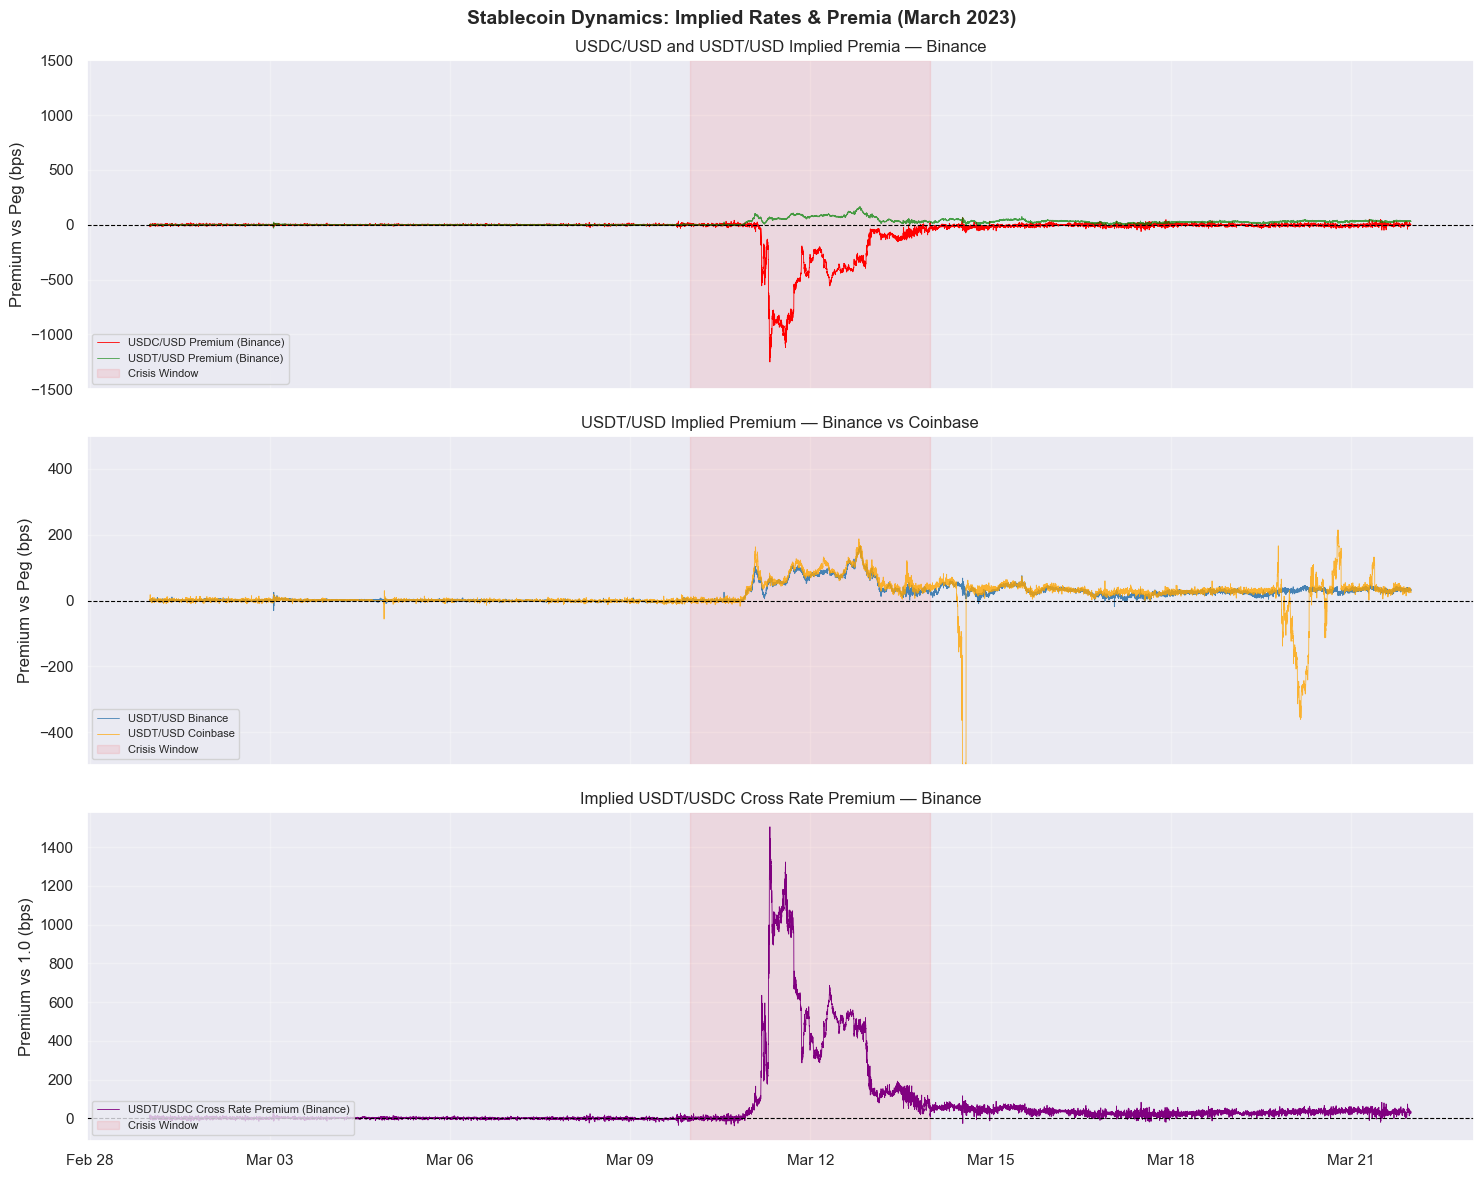

  Saved: stablecoin_premia_overview.png


In [7]:
print("\nGenerating plots...")

CRISIS_START = pd.Timestamp('2023-03-10', tz='UTC')
CRISIS_END   = pd.Timestamp('2023-03-14', tz='UTC')

def shade_crisis(ax):
    ax.axvspan(CRISIS_START, CRISIS_END, color='red', alpha=0.08, label='Crisis Window')
    ax.axhline(0, color='black', linestyle='--', linewidth=0.8)

# ── Implied USDC/USD and USDT/USD (Binance) ──
fig, axes = plt.subplots(3, 1, figsize=(15, 12), sharex=True)
fig.suptitle('Stablecoin Dynamics: Implied Rates & Premia (March 2023)', fontsize=14, fontweight='bold')

ax = axes[0]
ax.plot(prem_usdc_bnus.index, prem_usdc_bnus, color='red',   lw=0.6, label='USDC/USD Premium (Binance)')
ax.plot(prem_usdt_bnus.index, prem_usdt_bnus, color='green', lw=0.6, label='USDT/USD Premium (Binance)', alpha=0.7)
shade_crisis(ax)
ax.set_ylabel('Premium vs Peg (bps)')
ax.set_title('USDC/USD and USDT/USD Implied Premia — Binance')
ax.legend(loc='lower left', fontsize=8)
ax.grid(True, alpha=0.3)
ax.set_ylim(-1500, 1500)

# ── USDT/USD cross-exchange comparison ──
ax = axes[1]
ax.plot(prem_usdt_bnus.index, prem_usdt_bnus, color='steelblue', lw=0.6, label='USDT/USD Binance')
ax.plot(prem_usdt_cbse.index, prem_usdt_cbse, color='orange',    lw=0.6, label='USDT/USD Coinbase', alpha=0.8)
shade_crisis(ax)
ax.set_ylabel('Premium vs Peg (bps)')
ax.set_title('USDT/USD Implied Premium — Binance vs Coinbase')
ax.legend(loc='lower left', fontsize=8)
ax.grid(True, alpha=0.3)
ax.set_ylim(-500, 500)

# ── USDT/USDC implied cross rate premium ──
ax = axes[2]
ax.plot(prem_usdt_usdc.index, prem_usdt_usdc, color='purple', lw=0.6, label='USDT/USDC Cross Rate Premium (Binance)')
shade_crisis(ax)
ax.set_ylabel('Premium vs 1.0 (bps)')
ax.set_title('Implied USDT/USDC Cross Rate Premium — Binance')
ax.legend(loc='lower left', fontsize=8)
ax.grid(True, alpha=0.3)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
ax.xaxis.set_major_locator(mdates.DayLocator(interval=3))

plt.tight_layout()
plt.savefig('stablecoin_premia_overview.png', dpi=150, bbox_inches='tight')
plt.show()
print("  Saved: stablecoin_premia_overview.png")

## Cross-Exchange Dispersion over Time

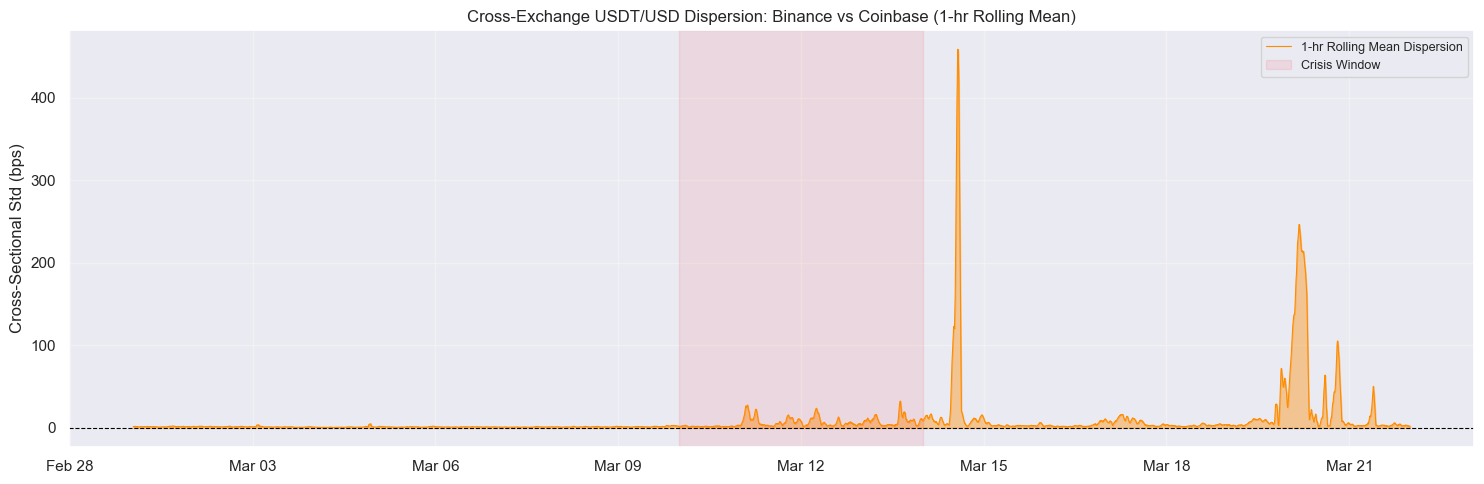

  Saved: cross_exchange_dispersion.png


In [9]:
# ── Cross-exchange dispersion over time ──
fig, ax = plt.subplots(figsize=(15, 5))

# Use 1-hour rolling mean to smooth
rolling_disp = disp_df['cross_dispersion_bps'].rolling(window=60).mean()
ax.fill_between(rolling_disp.index, rolling_disp, alpha=0.4, color='darkorange')
ax.plot(rolling_disp.index, rolling_disp, color='darkorange', lw=0.8, label='1-hr Rolling Mean Dispersion')
ax.axvspan(CRISIS_START, CRISIS_END, color='red', alpha=0.08, label='Crisis Window')
ax.axhline(0, color='black', linestyle='--', linewidth=0.8)
ax.set_title('Cross-Exchange USDT/USD Dispersion: Binance vs Coinbase (1-hr Rolling Mean)', fontsize=12)
ax.set_ylabel('Cross-Sectional Std (bps)')
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
ax.xaxis.set_major_locator(mdates.DayLocator(interval=3))
plt.tight_layout()
plt.savefig('cross_exchange_dispersion.png', dpi=150, bbox_inches='tight')
plt.show()
print("  Saved: cross_exchange_dispersion.png")

## Regime Summary Statistics

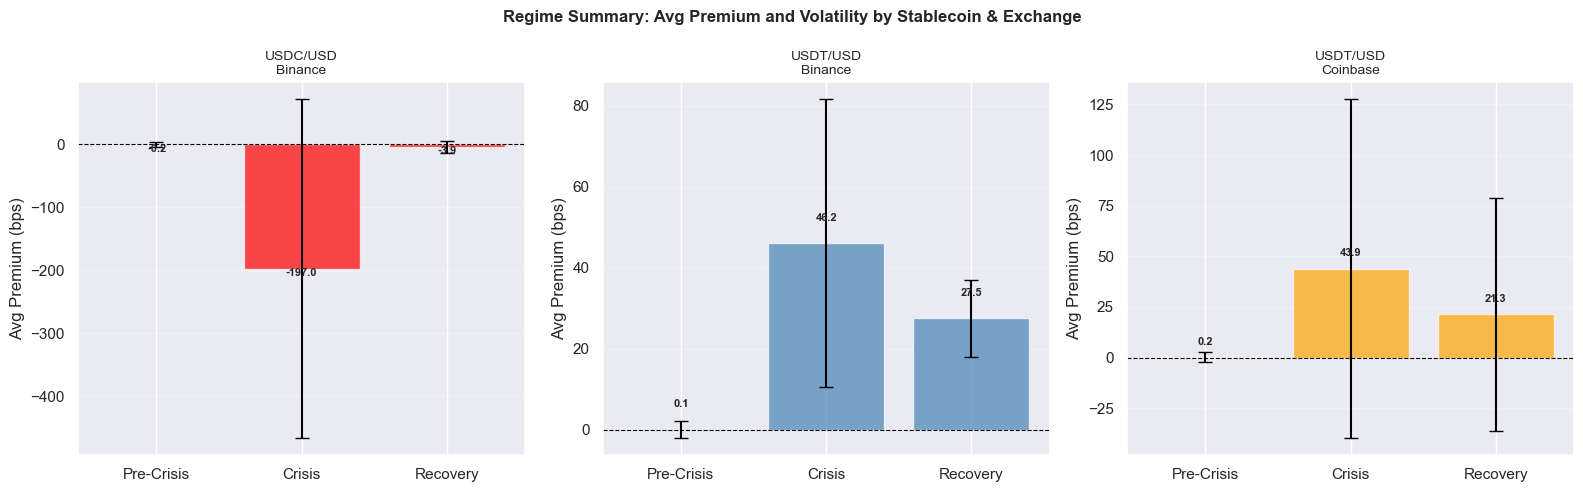

  Saved: regime_bar_chart.png


In [10]:
# ── Bar chart of regime summary statistics ──
fig, axes = plt.subplots(1, 3, figsize=(16, 5))
fig.suptitle('Regime Summary: Avg Premium and Volatility by Stablecoin & Exchange', fontsize=12, fontweight='bold')

pairs = [
    ('USDC/USD', 'Binance',  prem_usdc_bnus, 'red'),
    ('USDT/USD', 'Binance',  prem_usdt_bnus, 'steelblue'),
    ('USDT/USD', 'Coinbase', prem_usdt_cbse, 'orange'),
]
regime_labels = list(REGIMES.keys())
short_labels  = ['Pre-Crisis', 'Crisis', 'Recovery']

for ax_idx, (coin, exch, series, color) in enumerate(pairs):
    ax = axes[ax_idx]
    avgs = [regime_slice(series, s, e).mean() for _, (s, e) in REGIMES.items()]
    stds = [regime_slice(series, s, e).std()  for _, (s, e) in REGIMES.items()]
    bars = ax.bar(short_labels, avgs, color=color, alpha=0.7, yerr=stds, capsize=5, ecolor='black')
    ax.axhline(0, color='black', linestyle='--', linewidth=0.8)
    ax.set_title(f'{coin}\n{exch}', fontsize=10)
    ax.set_ylabel('Avg Premium (bps)')
    ax.grid(True, alpha=0.3, axis='y')
    # Annotate bars
    for bar, avg, std in zip(bars, avgs, stds):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + (5 if avg >= 0 else -15),
                f'{avg:.1f}', ha='center', va='bottom', fontsize=8, fontweight='bold')

plt.tight_layout()
plt.savefig('regime_bar_chart.png', dpi=150, bbox_inches='tight')
plt.show()
print("  Saved: regime_bar_chart.png")


## Distribution of Premiums by Regime

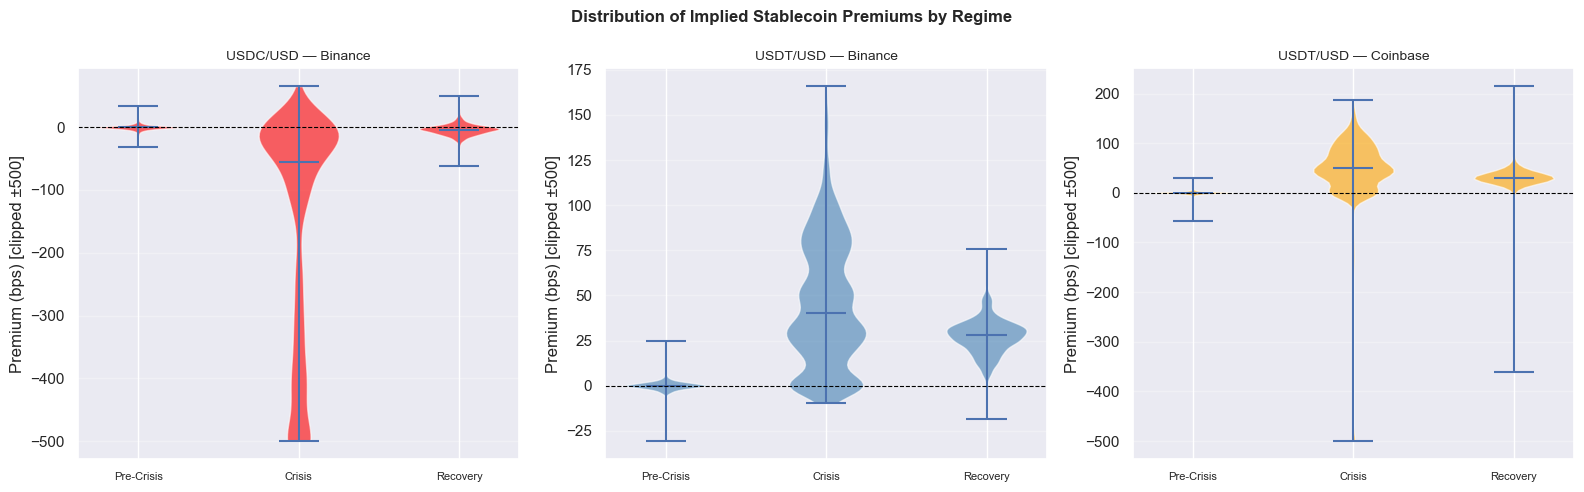

  Saved: regime_distributions.png


In [11]:
# ── Distribution of premiums by regime (violin/box plot) ──
fig, axes = plt.subplots(1, 3, figsize=(16, 5))
fig.suptitle('Distribution of Implied Stablecoin Premiums by Regime', fontsize=12, fontweight='bold')

for ax_idx, (coin, exch, series, color) in enumerate(pairs):
    ax = axes[ax_idx]
    data_by_regime = [regime_slice(series, s, e).clip(-500, 500).values
                      for _, (s, e) in REGIMES.items()]
    vp = ax.violinplot(data_by_regime, positions=[1, 2, 3], showmedians=True, showextrema=True)
    for body in vp['bodies']:
        body.set_facecolor(color)
        body.set_alpha(0.6)
    ax.set_xticks([1, 2, 3])
    ax.set_xticklabels(short_labels, fontsize=8)
    ax.set_title(f'{coin} — {exch}', fontsize=10)
    ax.set_ylabel('Premium (bps) [clipped ±500]')
    ax.axhline(0, color='black', linestyle='--', linewidth=0.8)
    ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('regime_distributions.png', dpi=150, bbox_inches='tight')
plt.show()
print("  Saved: regime_distributions.png")

## Dynamics Summary

In [12]:
print("\n" + "═"*60)
print("COMPLETE SUMMARY")
print("═"*60)
print("\nPremium Summary Table:")
print(summary_df.to_string(index=False))
print("\nCross-Exchange Dispersion Summary:")
print(disp_df_summary.to_string(index=False))


════════════════════════════════════════════════════════════
COMPLETE SUMMARY
════════════════════════════════════════════════════════════

Premium Summary Table:
Exchange      Coin               Regime  Avg Premium (bps)  Std Premium (bps)  Min (bps)  Max (bps)  N (minutes)
 Binance  USDC/USD Pre-Crisis (Mar 1–9)            -0.2046             3.6814   -32.3174    34.0537        12960
 Binance  USDC/USD   Crisis (Mar 10–14)          -197.0362           268.6913 -1251.2423    65.2875         7200
 Binance  USDC/USD Recovery (Mar 15–21)            -3.9413             9.3408   -61.6322    50.2217        10080
 Binance  USDT/USD Pre-Crisis (Mar 1–9)             0.1132             2.0872   -30.6158    25.0534        12960
 Binance  USDT/USD   Crisis (Mar 10–14)            46.1724            35.5024    -9.5392   165.8770         7200
 Binance  USDT/USD Recovery (Mar 15–21)            27.5237             9.5715   -18.5003    75.6462        10080
Coinbase  USDT/USD Pre-Crisis (Mar 1–9)      

## Kyle Lambda

In [13]:
# calc kyle lambda
def kyle_lambda_by_regime(trades_1m):
    df = trades_1m.copy()

    def fit_lambda(df):
        df = df[['ret', 'signed_dollar']].dropna()
        y = df['ret'].to_numpy()
        x = df['signed_dollar'].to_numpy()
        
        X = np.column_stack([np.ones_like(x), x])
        a, _, _, _ = np.linalg.lstsq(X, y, rcond=None)
        
        return float(a[1]) * 1000000.0

    kyle = df.groupby('regime', sort=False).apply(fit_lambda)
    kyle.name = 'lambda'
    
    return kyle

## Roll Spread

In [14]:
def roll_from_trades(trades_df):
    g = trades_df.copy()
    g = g[pd.to_numeric(g['price'], errors="coerce") > 0]
    P = g['price'].astype(float)
    
    side = np.where(g['taker_side_sell'], -1, 1)
    r = np.log(P).diff().dropna()
    roll_cov = np.cov(r[1:], r[:-1])[0,1]
    
    if pd.isna(roll_cov) or roll_cov >= 0: return np.nan
    
    roll_spread = 2 * np.sqrt(-roll_cov)
    roll_spread_bps = roll_spread * 10_000

    return roll_spread_bps

def roll_by_regime_from_trades(trades_df):       
    rs = trades_df.groupby("regime", sort=False).apply(lambda g: roll_from_trades(g))
    rs.name = "roll_spread"
    
    return rs.reindex(REGIME_ORDER)

## Effective Spread

In [15]:
def es_from_trades(trades_df, agg='median'):
    g = trades_df.copy()
    g = g[pd.to_numeric(g['price'], errors="coerce") > 0]
    P = g['price'].astype(float)
    
    side = np.where(g['taker_side_sell'], -1, 1)
    mid = g['mid'].astype(float)
    
    exp_spread = 2 * side * (P - mid)
    exp_spread_bps = (exp_spread / P) * 10000
    
    exp_spread_bps = exp_spread_bps.replace([np.inf, -np.inf], np.nan).dropna()
    exp_spread_bps = exp_spread_bps[(exp_spread_bps > -500) & (exp_spread_bps < 500)]
    
    if agg == 'mean':
        return exp_spread_bps.mean()
    else: 
        return exp_spread_bps.median()
    
def es_by_regime_from_trades(trades_df,  agg='mean'):
    es = trades_df.groupby("regime", sort=False).apply(lambda g: es_from_trades(g, agg=agg))
    es.name = "expected_spread"

    return es.reindex(REGIME_ORDER)

## Realized Spread

In [16]:
def rs_from_trades(trades_df, agg='median'):
    g = trades_df.copy()
    g = g[pd.to_numeric(g['price'], errors="coerce") > 0]
    P = g['price'].astype(float)
    
    side = np.where(g['taker_side_sell'], -1, 1)
    
    future_mid = g['future_mid'].astype(float)
    
    realized_spread = 2 * side * (P - future_mid)
    realized_spread_bps = (realized_spread / P) * 10000
    
    realized_spread_bps = realized_spread_bps.replace([np.inf, -np.inf], np.nan).dropna()
    realized_spread_bps = realized_spread_bps[(realized_spread_bps > -500) & (realized_spread_bps < 500)]
    
    if agg == 'mean':
        return realized_spread_bps.mean()
    else: 
        return realized_spread_bps.median()   

def rs_by_regime_from_trades(trades_df, agg='mean'):
    rs = trades_df.groupby("regime", sort=False).apply(lambda g: rs_from_trades(g, agg=agg))
    rs.name = "realized_spread"

    return rs.reindex(REGIME_ORDER)

## Liquidity Summary

In [17]:
# generate analysis summary value table
def summarize_liquidity(trades_df, roll_series, kyle_series, es_series, rs_series):
    
    def summ(g):
        nobs = len(g)
        n_trades = g['n_trades'].sum()
        vol_dollar = g['vol_dollar'].sum()
        rv_sum = g['rv_1m'].sum()
        rv_mean = g['rv_1m'].mean()
        sigma_ann = np.sqrt(rv_mean) * np.sqrt(525600)

        amihud_mean = g['amihud_1m'].mean()
        amihud_median = g['amihud_1m'].median()

        return pd.Series({
            'nobs': nobs,
            'n_trades': n_trades,
            'vol_dollar': vol_dollar,
            'rv_sum': rv_sum,
            'rv_mean': rv_mean,
            'sigma_ann': sigma_ann,
            'amihud_mean': amihud_mean,
            'amihud_median': amihud_median,
            'depth_proxy_vol_over_rv': vol_dollar / rv_mean if rv_mean > 0 else np.nan,
            'inv_amihud_median': 1.0 / amihud_median if amihud_median > 0 else np.nan,
            'n_trades_per_min': n_trades / nobs if nobs > 0 else np.nan,
            'avg_trade_dollar': vol_dollar / n_trades if n_trades > 0 else np.nan,
        })
    
    summ_df = trades_df.groupby('regime', observed=True).apply(summ).reindex(REGIME_ORDER)
    
    if roll_series is not None:
        summ_df['roll_spread'] = roll_series.reindex(REGIME_ORDER).to_numpy()
    if kyle_series is not None:
        summ_df['kyle_lambda_scaled'] = np.abs(kyle_series.reindex(REGIME_ORDER).to_numpy())
    if es_series is not None:
        summ_df['es_spread'] = es_series.reindex(REGIME_ORDER).to_numpy()
    if rs_series is not None:
        summ_df['rs_spread'] = rs_series.reindex(REGIME_ORDER).to_numpy()
    
    return summ_df

# runs across all exchanges and types
def run_liquidity_block(trade_files, agg):
    rows = []
    panels = []
    for spec in trade_files:
        trades, ohlc = load_trades_ohlc(spec['trade_path'], spec['ohlc_path'])
        panel = resample_trades(trades)
        panels.append({'exchange': spec['exchange'], 'pair': spec['pair'], 'panel': panel})
        
        roll = roll_by_regime_from_trades(trades)
        kyle = kyle_lambda_by_regime(panel)
        es = es_by_regime_from_trades(trades, agg=agg)
        rs = rs_by_regime_from_trades(trades, agg=agg)

        summ = summarize_liquidity(panel, roll, kyle, es, rs)
        summ = summ.reset_index().rename(columns={'index': 'regime'})
        summ['exchange'] = spec['exchange']
        summ['pair'] = spec['pair']
        rows.append(summ)

    out = pd.concat(rows, ignore_index=True)
    out['regime'] = pd.Categorical(out['regime'], categories=REGIME_ORDER, ordered=True)
    out = out.sort_values(['exchange', 'pair', 'regime']).reset_index(drop=True)
    
    return out, panels

# plot table for given metric
def plot_metric(all_summary, metric, title, log=False):
    piv = all_summary.pivot_table(index=['exchange', 'pair'], columns='regime', values=metric, aggfunc='mean')
    piv = piv.reindex(columns=REGIME_ORDER)
    ax = piv.plot(kind='bar', figsize=(10, 4))
    ax.set_title(title)
    ax.set_ylabel(metric)
    if log: ax.set_yscale('log')
    ax.tick_params(axis='x', labelrotation=45)
    ax.legend(title='regime')

    plt.tight_layout()
    plt.show()
    
all_summary, all_panels = run_liquidity_block(trade_files, agg='mean')
all_summary

,regime,nobs,n_trades,vol_dollar,rv_sum,rv_mean,sigma_ann,amihud_mean,amihud_median,depth_proxy_vol_over_rv,inv_amihud_median,n_trades_per_min,avg_trade_dollar,roll_spread,kyle_lambda_scaled,es_spread,rs_spread,exchange,pair
0,calm,12818.0,1010373.0,1.1282e+09,0.0033,2.5387e-07,0.3653,3.5856e-08,4.7147e-09,4.4438e+15,2.1210e+08,78.8245,1116.5874,0.9781,0.0027,-0.4636,-0.0008,binance,BTC/USD
1,stress,7198.0,1601108.0,1.3028e+09,0.0072,1.0030e-06,0.7261,1.2216e-08,4.1701e-09,1.2989e+15,2.3980e+08,222.4379,813.7027,1.8801,0.0034,-0.9191,0.0492,binance,BTC/USD
2,post,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,binance,BTC/USD
3,calm,4614.0,39506.0,2.9594e+07,0.0029,6.2668e-07,0.5739,1.1024e-06,1.1812e-07,4.7223e+13,8.4656e+06,8.5622,749.1046,0.8691,0.0278,-0.2739,1.3643,binance,BTC/USDC
4,stress,3660.0,61338.0,2.4318e+07,0.0281,7.6747e-06,2.0084,7.4358e-06,2.6044e-07,3.1686e+12,3.8396e+06,16.7590,396.4553,17.2087,0.0591,-1.8006,-6.1392,binance,BTC/USDC
5,post,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,binance,BTC/USDC
6,calm,12069.0,418606.0,4.3146e+08,0.0033,2.7424e-07,0.3797,1.4314e-07,1.3253e-08,1.5733e+15,7.5456e+07,34.6844,1030.7044,1.1412,0.0066,-0.2345,0.7373,binance,BTC/USDT
7,stress,7053.0,413888.0,5.8810e+08,0.0072,1.0268e-06,0.7346,1.8860e-07,9.2672e-09,5.7274e+14,1.0791e+08,58.6825,1420.9089,1.7904,0.0054,-0.6788,0.4012,binance,BTC/USDT
8,post,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,binance,BTC/USDT
9,calm,12674.0,2636263.0,2.3746e+09,0.0033,2.6266e-07,0.3716,6.1543e-09,1.8785e-09,9.0405e+15,5.3235e+08,208.0056,900.7499,0.4200,0.0012,0.1601,-0.4524,coinbase,BTC/USD


## Volatility Dynamics During Market Stress

- The empirical data reveals a crystal-clear signature of the March 2023 USDC depeg, most notably in the volatility profiles of stablecoin versus fiat quote currencies. Looking at the Annualized Return Volatility chart, Binance BTC/USDC experienced extreme instability where volatility jumped from 57% in the calm regime to a massive 200% during the stress regime, before settling back to 83% post-crisis.

- This volatility was accompanied by a severe panic-induced "flight to volume." As seen in the Trade Intensity chart, despite the stress period lasting only four days, BTC/USDC recorded 61,338 trades—vastly outpacing the 39,506 trades seen in the entire prolonged calm period preceding it. Without the robust framework of the GENIUS Act, legacy stablecoins were highly susceptible to traditional banking panics, transmitting off-chain banking risk directly into severe microstructure volatility in cross-currency crypto pairs.

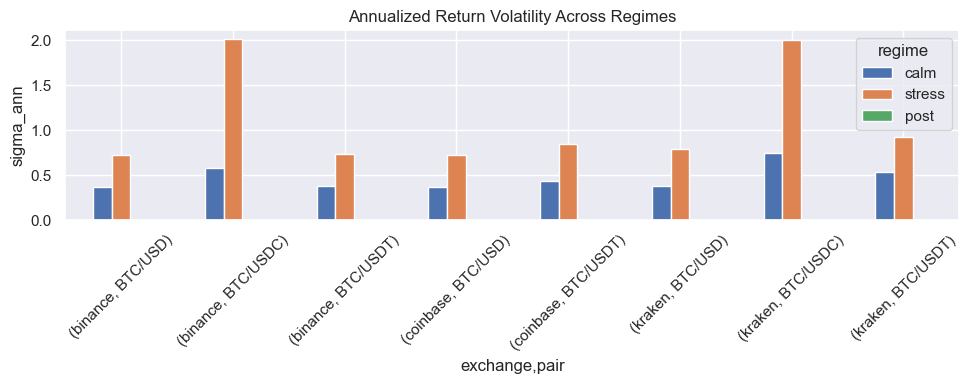

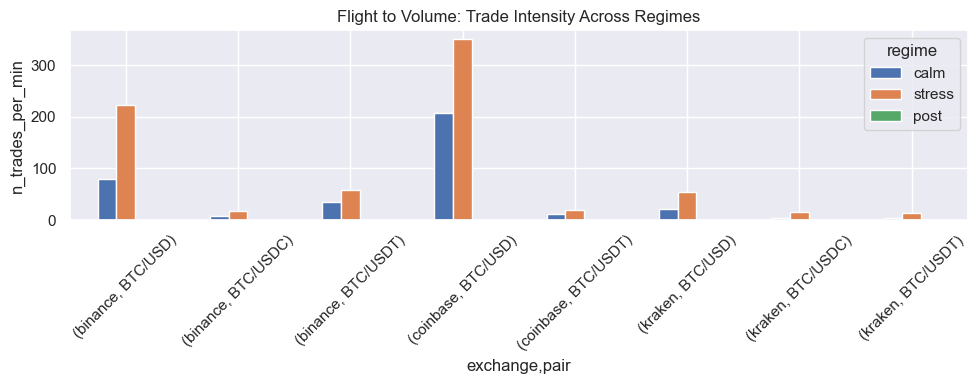

In [18]:
plot_metric(all_summary, 'sigma_ann', 'Annualized Return Volatility Across Regimes')
plot_metric(all_summary, 'n_trades_per_min', 'Flight to Volume: Trade Intensity Across Regimes')

## Market Depth and Resilience

- When analyzing order book absorption and price impact, pure fiat pairs were better in liquidity depth compared to their stablecoin counterparts. The Median Inverse Amihud Illiquidity chart illustrates that Fiat USD acts as an uncontested liquidity anchor. Coinbase BTC/USD’s inverse Amihud depth completely dwarfs all other pairs by orders of magnitude (note the logarithmic scale).

- The fiat pairs demonstrated remarkable resilience. During the height of the banking stress, the Amihud median for Coinbase BTC/USD actually remained stable and even slightly improved (from 1.87×10−9 to 1.52×10−9). The higher inverse values imply deeper market depth, meaning the fiat order book effortlessly absorbed the massive volume surge with minimal price impact for traders. In contrast, unregulated stablecoin pairs lacked this structural resilience when the peg came under pressure.

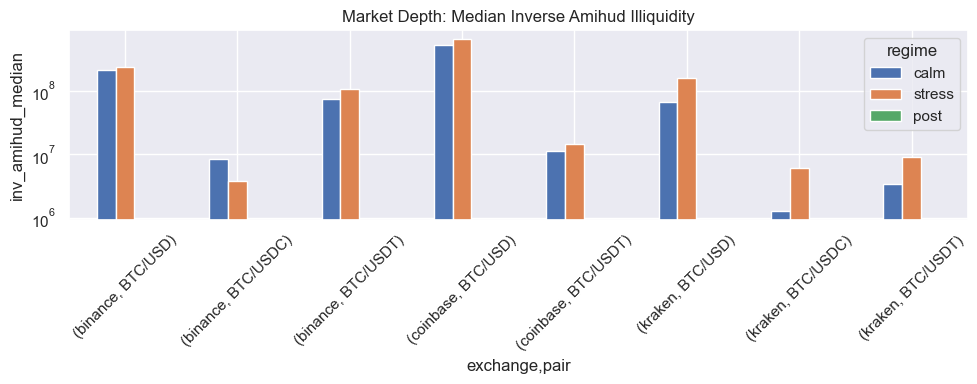

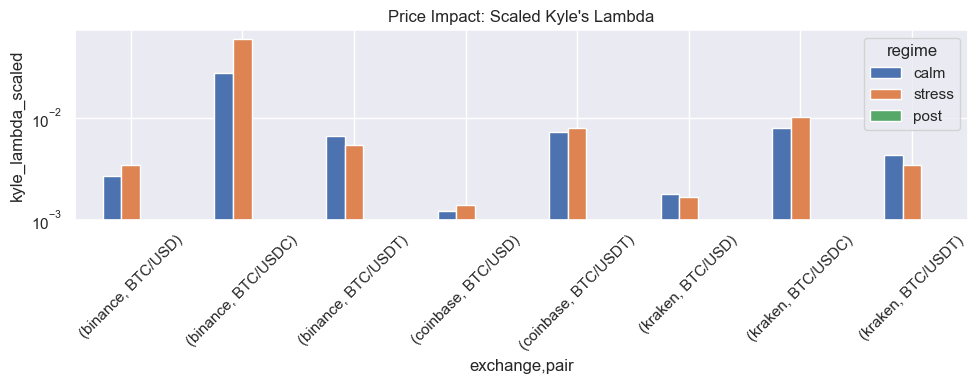

In [19]:
plot_metric(all_summary, 'inv_amihud_median', 'Market Depth: Median Inverse Amihud Illiquidity', True) # higher
plot_metric(all_summary, 'kyle_lambda_scaled', 'Price Impact: Scaled Kyle\'s Lambda', True) # lower

## Spread Proxies
- Bid-ask spread proxies further illustrate the fragmentation of liquidity across quote currencies. The Roll Implied Spreads chart starkly captures the evaporation of liquidity in the stablecoin market during the crisis. For Binance BTC/USDC, the roll spread spiked from a baseline of 0.86 bps to an astonishing 17.2 bps during the stress regime.

- Conversely, Coinbase BTC/USD maintained the tightest spread by far. In the calm period, it averaged just 0.42 bps, compared to Binance BTC/USDT (1.14 bps) and Binance BTC/USDC (0.86 bps). Even during the peak of the stress period, Coinbase's BTC/USD spread widened to a mere 1.11 bps, effectively resisting the contagion that drove USDC spreads up by 20x.

- The Effective Spread show values hovering around -0.5 to +0.5 bps. These metrics were estimated using 1-second OHLC mid-prices due to the absence of Level 2 quote (order book) data, which introduces intra-second microstructure latency artifacts. Because we are using 1-second OHLC data to proxy the mid-price, high-frequency trades often appear to execute "inside" or "past" the stale 1-second mid-price, resulting in slightly negative effective spreads. Interestingly, Coinbase leans slightly positive while Binance leans slightly negative, likely due to micro-differences in how their respective matching engines report trade timestamps. Because of these L2 data limitations, this study relies on the Roll Spread, Kyle's Lambda, and Amihud Illiquidity, all of which are calculated from executed trades as the most robust measures of market friction.

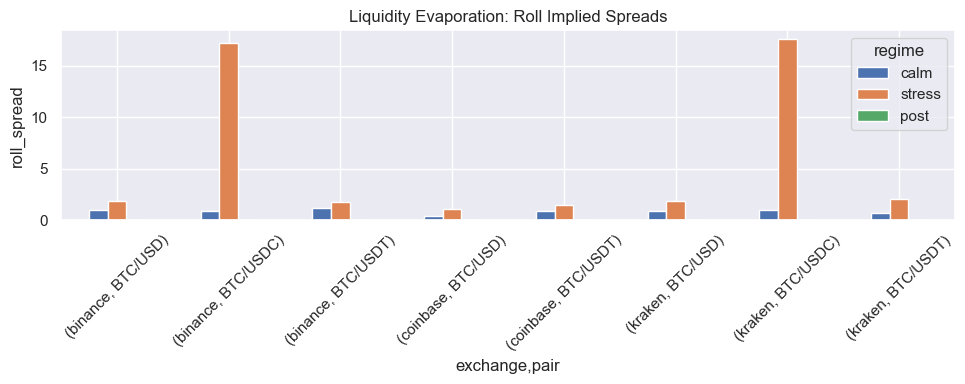

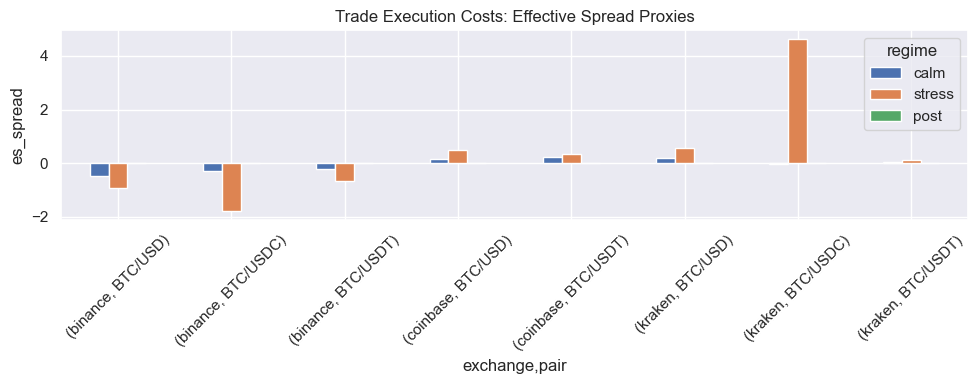

In [20]:
plot_metric(all_summary, "roll_spread", "Liquidity Evaporation: Roll Implied Spreads")
plot_metric(all_summary, "es_spread", "Trade Execution Costs: Effective Spread Proxies")

## Volume Fragmentation

In [21]:
explain_block(
    "Volume Fragmentation (HHI + venue shares + dominance shifts).",
    "Trades data, 1-minute bins, volume=amount. Pairs: BTC/USD & BTC/USDT across bnus/cbse/krkn; BTC/USDC across bnus/krkn.",
    "Higher HHI = more concentration. Dominance shift is significant only if >5 percentage points."
)

PAIR_VENUE_MAP = {
    "BTC/USD": ["binance", "coinbase", "kraken"],
    "BTC/USDT": ["binance", "coinbase", "kraken"],
    "BTC/USDC": ["binance", "kraken"],
}

def volume_fragmentation_multi(trades_df, pair_venue_map, freq="1min", sig_pp=5.0):
    hhi_all, share_all = [], []

    for pair, venues in pair_venue_map.items():
        d = trades_df[
            (trades_df["pair"] == pair) & (trades_df["exchange"].isin(venues))
        ].copy()

        d["time_bin"] = d.index.floor(freq)

        # per-minute venue volume
        vv = (
            d.groupby(["time_bin", "exchange"], as_index=False)["amount"]
            .sum()
            .rename(columns={"amount": "venue_vol"})
        )

        # full grid (avoid missing-minute bias)
        minutes = pd.date_range("2023-03-01", "2023-03-21 23:59:00", freq=freq, tz="UTC")
        grid = pd.MultiIndex.from_product(
            [minutes, venues], names=["time_bin", "exchange"]
        ).to_frame(index=False)

        vv = grid.merge(vv, on=["time_bin", "exchange"], how="left").fillna({"venue_vol": 0.0})

        tot = (
            vv.groupby("time_bin", as_index=False)["venue_vol"]
            .sum()
            .rename(columns={"venue_vol": "total_vol"})
        )

        s = vv.merge(tot, on="time_bin", how="left")
        s["share"] = np.where(s["total_vol"] > 0, s["venue_vol"] / s["total_vol"], np.nan)
        s["pair"] = pair
        s = add_regime_labels(s, ts_col="time_bin")
        s = s[s["regime"] != "out_of_scope"]
        share_all.append(s)

        h = (
            s.groupby(["pair", "time_bin"], as_index=False)
            .agg(hhi=("share", lambda x: np.nansum(np.square(x))))
        )
        h = add_regime_labels(h, ts_col="time_bin")
        h = h[h["regime"] != "out_of_scope"]
        hhi_all.append(h)

    shares_df = pd.concat(share_all, ignore_index=True)
    hhi_ts_df = pd.concat(hhi_all, ignore_index=True)

    hhi_summary = (
        hhi_ts_df.groupby(["pair", "regime"], as_index=False)
        .agg(
            mean_hhi=("hhi", "mean"),
            median_hhi=("hhi", "median"),
            p90_hhi=("hhi", lambda x: np.nanpercentile(x, 90)),
            n_bins=("hhi", "count"),
        )
        .sort_values(["pair", "regime"])
    )

    share_summary = (
        shares_df.groupby(["pair", "regime", "exchange"], as_index=False)
        .agg(mean_share=("share", "mean"))
        .sort_values(["pair", "regime", "exchange"])
    )

    # dominant venue + significance vs calm
    valid_share_summary = share_summary.dropna(subset=["mean_share"]).copy()

    if valid_share_summary.empty:
        dom = pd.DataFrame(columns=[
            "pair", "regime", "dominant_exchange", "dominant_share",
            "calm_dominant_exchange", "calm_dominant_share",
            "delta_vs_calm_pp", "significance"
        ])
    else:
        dom_idx = valid_share_summary.groupby(["pair", "regime"])["mean_share"].idxmax()
        dom = valid_share_summary.loc[dom_idx].copy()

        dom = dom.rename(
            columns={"exchange": "dominant_exchange", "mean_share": "dominant_share"}
        )

        calm_ref = dom[dom["regime"] == "calm"][
            ["pair", "dominant_exchange", "dominant_share"]
        ].rename(
            columns={
                "dominant_exchange": "calm_dominant_exchange",
                "dominant_share": "calm_dominant_share",
            }
        )

        dom = dom.merge(calm_ref, on="pair", how="left")
        dom["delta_vs_calm_pp"] = (dom["dominant_share"] - dom["calm_dominant_share"]) * 100
        dom["significance"] = np.where(
            dom["delta_vs_calm_pp"].abs() > sig_pp,
            "significant",
            "insignificant"
        )

    return shares_df, hhi_ts_df, hhi_summary, share_summary, dom

shares_df, hhi_ts_df, hhi_summary_df, share_summary_df, dom_summary_df = volume_fragmentation_multi(
    trades_all, PAIR_VENUE_MAP, freq="1min", sig_pp=5.0
)

display(hhi_summary_df)
display(share_summary_df)
display(dom_summary_df.sort_values(["pair", "regime"]))


Volume Fragmentation (HHI + venue shares + dominance shifts).
Data used: Trades data, 1-minute bins, volume=amount. Pairs: BTC/USD & BTC/USDT across bnus/cbse/krkn; BTC/USDC across bnus/krkn.
How to gauge: Higher HHI = more concentration. Dominance shift is significant only if >5 percentage points.



,pair,regime,mean_hhi,median_hhi,p90_hhi,n_bins
0,BTC/USD,calm,0.5714,0.5321,0.7999,12960
1,BTC/USD,post_crash,0.5000,0.4801,0.6707,10080
2,BTC/USD,stress,0.5324,0.5040,0.7319,7200
3,BTC/USDC,calm,0.6323,0.9887,1.0000,12960
4,BTC/USDC,post_crash,0.7121,0.9795,1.0000,10080
5,BTC/USDC,stress,0.7876,0.9715,1.0000,7200
6,BTC/USDT,calm,0.7606,0.7805,0.9990,12960
7,BTC/USDT,post_crash,0.6842,0.6325,0.9972,10080
8,BTC/USDT,stress,0.7044,0.7025,0.9668,7200


,pair,regime,exchange,mean_share
0,BTC/USD,calm,binance,0.2930
1,BTC/USD,calm,coinbase,0.5999
2,BTC/USD,calm,kraken,0.1072
3,BTC/USD,post_crash,binance,0.2991
4,BTC/USD,post_crash,coinbase,0.5541
5,BTC/USD,post_crash,kraken,0.1468
6,BTC/USD,stress,binance,0.2472
7,BTC/USD,stress,coinbase,0.5756
8,BTC/USD,stress,kraken,0.1772
9,BTC/USDC,calm,binance,0.6776


,pair,regime,dominant_exchange,dominant_share,calm_dominant_exchange,calm_dominant_share,delta_vs_calm_pp,significance
0,BTC/USD,calm,coinbase,0.5999,coinbase,0.5999,0.0000,insignificant
1,BTC/USD,post_crash,coinbase,0.5541,coinbase,0.5999,-4.5777,insignificant
2,BTC/USD,stress,coinbase,0.5756,coinbase,0.5999,-2.4225,insignificant
3,BTC/USDC,calm,binance,0.6776,binance,0.6776,0.0000,insignificant
4,BTC/USDC,post_crash,binance,0.5921,binance,0.6776,-8.5492,significant
5,BTC/USDC,stress,kraken,0.5823,binance,0.6776,-9.5359,significant
6,BTC/USDT,calm,binance,0.7520,binance,0.7520,0.0000,insignificant
7,BTC/USDT,post_crash,binance,0.6585,binance,0.7520,-9.3512,significant
8,BTC/USDT,stress,binance,0.7040,binance,0.7520,-4.8017,insignificant


## Rolling Venue Volume Share
Assumption: A dominance shift is considered significant only if the dominant venue share changes by more than 5 percentage points.

In the three-exchange setting (bnus, cbse, krkn), volume fragmentation still shows mostly stable leadership during stress for BTC/USD and BTC/USDT, but with a stronger shift in BTC/USDC. For BTC/USD, Coinbase remains dominant across all regimes (59.99% calm, 57.56% stress, 55.41% post-crash), and the calm-to-stress change is -2.43 percentage points, which is insignificant under the 5-point threshold. For BTC/USDT, Binance remains dominant (75.20% calm, 70.40% stress, 65.85% post-crash); the calm-to-stress shift is -4.80 points (insignificant), while the post-crash decline versus calm is -9.35 points (significant), indicating meaningful rebalancing away from Binance but not a leadership reversal. The strongest structural shift appears in BTC/USDC (bnus vs krkn), where dominance flips from Binance in calm (67.76%) to Kraken in stress (58.23%), a significant crash-time migration, before partially reverting post-crash (Binance 59.21%). Overall, the evidence indicates that stress primarily widened pricing frictions, while large venue-share migration was concentrated in the USDC-quoted market rather than broad-based across all pairs.

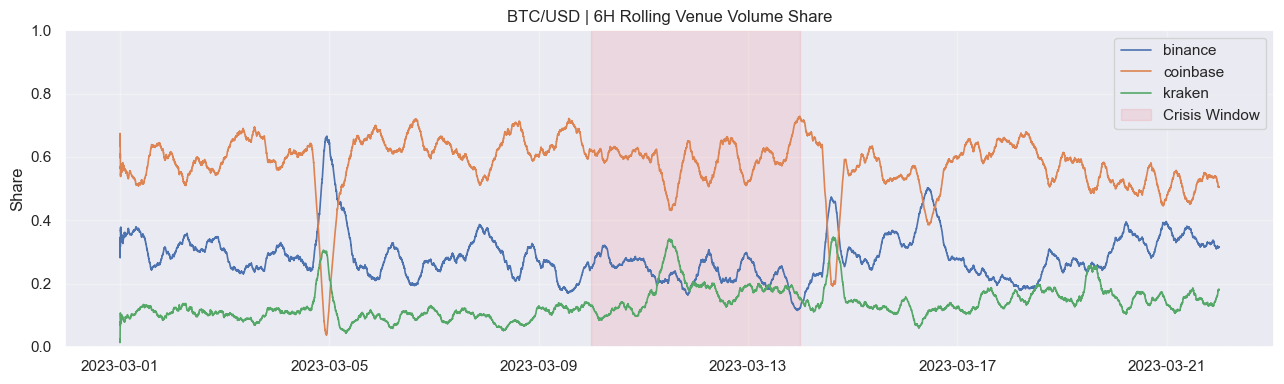

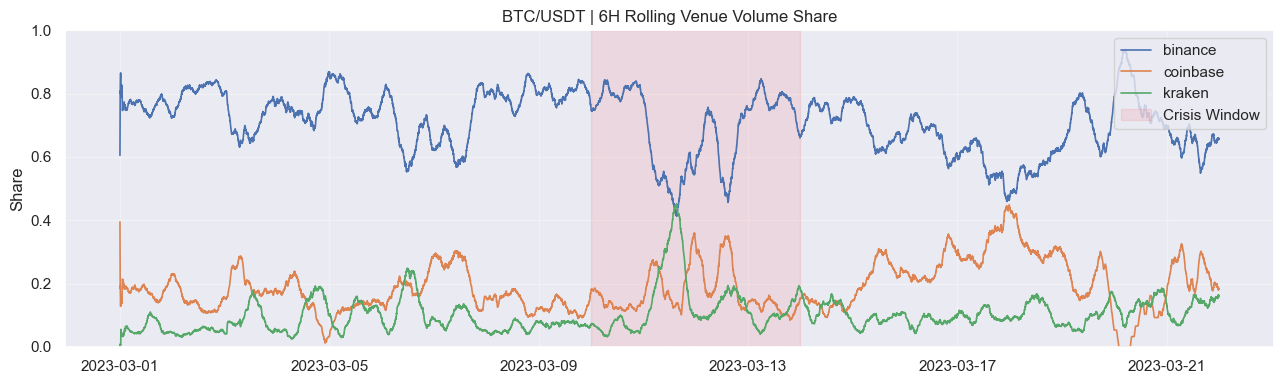

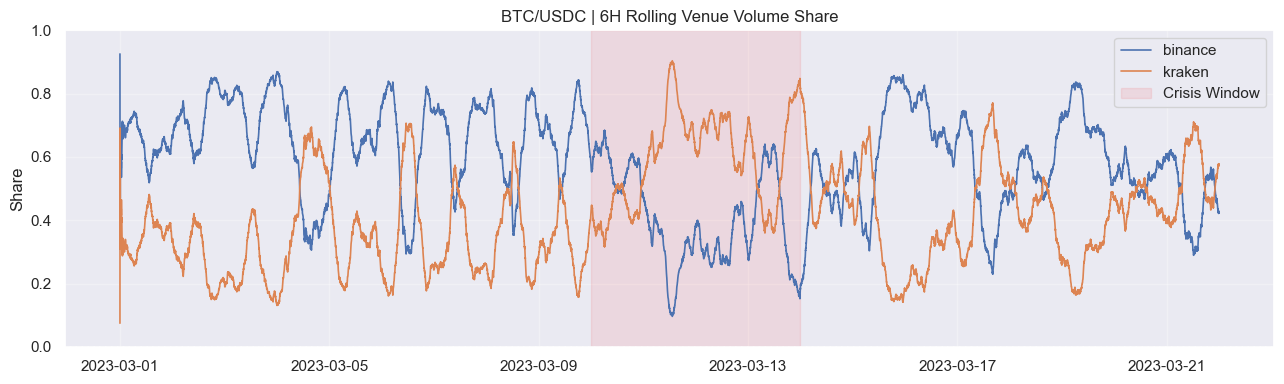

In [22]:
for pair, venues in PAIR_VENUE_MAP.items():
    d = shares_df[shares_df["pair"] == pair].copy()
    w = d.pivot_table(index="time_bin", columns="exchange", values="share", aggfunc="mean").sort_index()
    w = w[venues].rolling("6H").mean()  # smooth

    fig, ax = plt.subplots(figsize=(13, 4))
    for ex in venues:
        ax.plot(w.index, w[ex], label=ex, linewidth=1.2)
    shade_crisis(ax)
    ax.set_title(f"{pair} | 6H Rolling Venue Volume Share")
    ax.set_ylabel("Share")
    ax.set_ylim(0, 1)
    ax.grid(alpha=0.3)
    ax.legend(loc="upper right")
    plt.tight_layout()
    plt.show()

## Cross-Venue Dislocation
Cross-venue dislocation clearly worsens during stress in the three-exchange setup, and the strongest damage remains in BTC/USD (with the most extreme break in BTC/USDC). For BTC/USD, aggregate mean pairwise dislocation rises from 1.57 bps in calm to 7.79 bps in stress (about 5.0x), confirming a material divergence in cross-venue prices when markets were under pressure. Post-crash conditions improve relative to stress but remain above calm (mean 5.82 bps), which indicates incomplete reintegration.

For BTC/USDT, stress dislocation also increases but at a lower magnitude: mean rises from 1.69 to 3.75 bps (about 2.2x), with post-crash still elevated at 3.29 bps. For BTC/USDC (bnus-krkn), the stress effect is much larger: mean dislocation jumps from 3.45 to 52.04 bps (about 15x), then declines to 5.98 bps post-crash. The key takeaway is that stress primarily damaged cross-venue price integration, with the sharpest breakdown in USDC-quoted markets and a strong but smaller breakdown in USD-quoted markets.

In [23]:
explain_block(
    "Cross-venue dislocation (pairwise and aggregate).",
    "Trades data, 1-minute VWAP per venue. For 3 venues: all pairwise dislocations + mean/max pairwise per minute.",
    "Higher bps = weaker cross-venue integration; stress amplification indicates market friction."
)

def dislocation_multi(trades_df, pair_venue_map, freq="1min"):
    pairwise_rows, agg_rows = [], []

    for pair, venues in pair_venue_map.items():
        d = trades_df[(trades_df["pair"] == pair) & (trades_df["exchange"].isin(venues))].copy()
        d["time_bin"] = d.index.floor(freq)
        d["notional"] = d["price"] * d["amount"]

        v = d.groupby(["time_bin", "exchange"], as_index=False).agg(notional=("notional", "sum"), vol=("amount", "sum"))
        v["vwap"] = np.where(v["vol"] > 0, v["notional"] / v["vol"], np.nan)
        w = v.pivot(index="time_bin", columns="exchange", values="vwap").sort_index()

        bps_cols = []
        for a, b in combinations(venues, 2):
            z = w[[a, b]].dropna().copy()
            z["abs_bps"] = ((z[a] - z[b]).abs() / ((z[a] + z[b]) / 2.0)) * 10000.0
            z["pair"] = pair
            z["venue_pair"] = f"{a}-{b}"
            z = add_regime_labels(z)
            z = z[z["regime"] != "out_of_scope"]
            pairwise_rows.append(z[["pair", "venue_pair", "regime", "abs_bps"]])

            w[f"bps_{a}_{b}"] = ((w[a] - w[b]).abs() / ((w[a] + w[b]) / 2.0)) * 10000.0
            bps_cols.append(f"bps_{a}_{b}")

        # aggregate across all available venue pairs each minute
        if bps_cols:
            m = w[bps_cols].copy()
            m["pair"] = pair
            m["mean_pairwise_bps"] = m[bps_cols].mean(axis=1, skipna=True)
            m["max_pairwise_bps"] = m[bps_cols].max(axis=1, skipna=True)
            m = m.dropna(subset=["mean_pairwise_bps"])
            m["time_bin"] = m.index
            m = add_regime_labels(m, ts_col="time_bin")
            m = m[m["regime"] != "out_of_scope"]
            agg_rows.append(m[["pair", "regime", "mean_pairwise_bps", "max_pairwise_bps"]])

    pairwise_df = pd.concat(pairwise_rows, ignore_index=True)
    pairwise_summary = (
        pairwise_df.groupby(["pair", "venue_pair", "regime"], as_index=False)
        .agg(
            mean_bps=("abs_bps", "mean"),
            median_bps=("abs_bps", "median"),
            p90_bps=("abs_bps", lambda x: np.nanpercentile(x, 90)),
            max_bps=("abs_bps", "max"),
            n_minutes=("abs_bps", "count"),
        )
        .sort_values(["pair", "venue_pair", "regime"])
    )

    agg_df = pd.concat(agg_rows, ignore_index=True)
    agg_summary = (
        agg_df.groupby(["pair", "regime"], as_index=False)
        .agg(
            mean_pairwise_bps=("mean_pairwise_bps", "mean"),
            p90_pairwise_bps=("mean_pairwise_bps", lambda x: np.nanpercentile(x, 90)),
            max_pairwise_bps=("max_pairwise_bps", "max"),
            n_minutes=("mean_pairwise_bps", "count"),
        )
        .sort_values(["pair", "regime"])
    )
    return pairwise_df, pairwise_summary, agg_summary

disloc_pairwise_df, disloc_pairwise_summary_df, disloc_agg_summary_df = dislocation_multi(
    trades_all, PAIR_VENUE_MAP, freq="1min"
)

display(disloc_agg_summary_df)
display(disloc_pairwise_summary_df)


Cross-venue dislocation (pairwise and aggregate).
Data used: Trades data, 1-minute VWAP per venue. For 3 venues: all pairwise dislocations + mean/max pairwise per minute.
How to gauge: Higher bps = weaker cross-venue integration; stress amplification indicates market friction.



,pair,regime,mean_pairwise_bps,p90_pairwise_bps,max_pairwise_bps,n_minutes
0,BTC/USD,calm,1.5670,3.1116,28.3305,12958
1,BTC/USD,post_crash,5.8203,12.7225,55.0855,10080
2,BTC/USD,stress,7.7921,16.2198,89.7188,7200
3,BTC/USDC,calm,3.4541,7.5131,33.0486,2880
4,BTC/USDC,post_crash,5.9846,13.0750,37.4441,3487
5,BTC/USDC,stress,52.0415,111.1709,1149.8126,3587
6,BTC/USDT,calm,1.6867,3.5870,37.0319,11790
7,BTC/USDT,post_crash,3.2920,6.4108,127.8113,9406
8,BTC/USDT,stress,3.7518,7.5501,72.7963,7035


,pair,venue_pair,regime,mean_bps,median_bps,p90_bps,max_bps,n_minutes
0,BTC/USD,binance-coinbase,calm,1.0085,0.7432,2.0847,28.3305,12609
1,BTC/USD,binance-coinbase,post_crash,4.4758,2.8022,11.2370,47.1406,10080
2,BTC/USD,binance-coinbase,stress,9.4359,6.0300,22.5307,89.7188,6946
3,BTC/USD,binance-kraken,calm,1.9706,1.4677,4.2573,22.9346,12841
4,BTC/USD,binance-kraken,post_crash,6.8042,4.5856,16.4595,44.3444,10068
5,BTC/USD,binance-kraken,stress,8.3579,5.6839,19.6270,61.4623,7199
6,BTC/USD,coinbase-kraken,calm,1.7271,1.2258,3.8943,22.5726,12632
7,BTC/USD,coinbase-kraken,post_crash,6.1696,3.5646,17.4931,55.0855,10068
8,BTC/USD,coinbase-kraken,stress,5.4295,3.6547,12.3138,59.4554,6947
9,BTC/USDC,binance-kraken,calm,3.4541,2.5432,7.5131,33.0486,2880


### Dislocation Regime Comparison

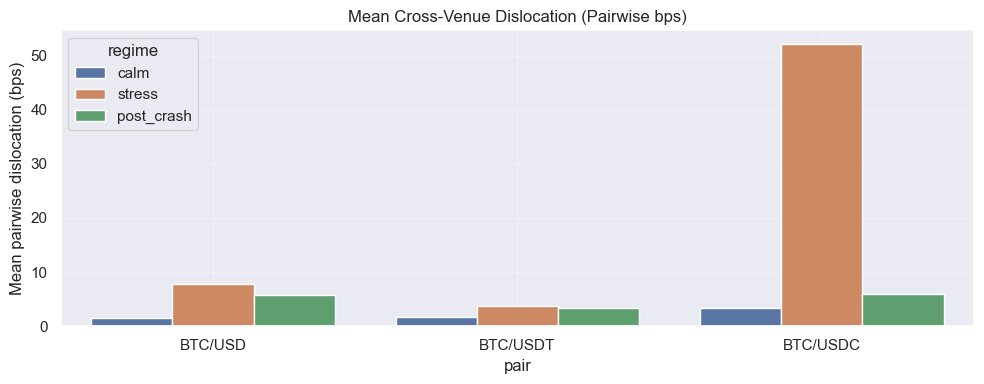

In [24]:
fig, ax = plt.subplots(figsize=(10, 4))
sns.barplot(
    data=disloc_agg_summary_df,
    x="pair",
    y="mean_pairwise_bps",
    hue="regime",
    order=["BTC/USD", "BTC/USDT", "BTC/USDC"],
    hue_order=["calm", "stress", "post_crash"],
    ax=ax
)
ax.set_title("Mean Cross-Venue Dislocation (Pairwise bps)")
ax.set_ylabel("Mean pairwise dislocation (bps)")
ax.grid(alpha=0.25)
plt.tight_layout()
plt.show()

## Price Discovery
Price discovery in the three-exchange setting still indicates fast transmission at the 1-minute horizon, with stress showing up more in directional asymmetry than in timing delays. Lag-correlation results keep a best lag of 0 across pairs and venue combinations, implying no clear minute-level delay in price adjustment. Contemporaneous co-movement remains high for BTC/USD (bnus-cbse around 0.97; bnus-krkn and cbse-krkn rising into roughly 0.91–0.93 in stress/post-crash), while BTC/USDT is slightly lower but still strong (about 0.77–0.91 depending on venue pair and regime).

Granger results provide the directional detail: BTC/USD is largely bidirectional across regimes, but flow into Kraken is often statistically stronger than the reverse direction. For BTC/USDT, the key stress asymmetry persists in bnus-cbse: Binance -> Coinbase remains strongly significant, while Coinbase -> Binance becomes insignificant in stress (p ≈ 0.175), indicating Binance-led information flow under pressure. For BTC/USDC (bnus-krkn), contemporaneous correlation drops sharply in stress (to about 0.34) even though Granger remains significant both ways, showing that stress can weaken synchronous alignment without eliminating predictive linkage. Overall, prices move together in real time, but stress redistributes influence and weakens integration quality in a pair-dependent way.

In [25]:
explain_block(
    "Price discovery across exchange pairs (lag-correlation + Granger).",
    "OHLC close prices, resampled to 1-minute returns; tested pairwise across venue combinations.",
    "best_lag=0 => synchronous minute updates; Granger p<0.05 => predictive information flow in that direction."
)

warnings.filterwarnings(
    "ignore",
    message="verbose is deprecated since functions should not print results",
    category=FutureWarning
)

def price_discovery_multi(ohlc_df, pair_venue_map, freq="1min", max_lag=5):
    rows = []

    for pair, venues in pair_venue_map.items():
        d = ohlc_df[(ohlc_df["pair"] == pair) & (ohlc_df["exchange"].isin(venues))].copy()
        d["time_bin"] = d.index.floor(freq)
        close_1m = d.groupby(["time_bin", "exchange"], as_index=False)["close"].last()
        w = close_1m.pivot(index="time_bin", columns="exchange", values="close").sort_index()

        for a, b in combinations(venues, 2):
            x = w[[a, b]].dropna().copy()
            x["ret_a"] = np.log(x[a]).diff()
            x["ret_b"] = np.log(x[b]).diff()
            x = x.dropna(subset=["ret_a", "ret_b"])
            x = add_regime_labels(x)
            x = x[x["regime"] != "out_of_scope"]

            for rg in ["calm", "stress", "post_crash"]:
                y = x[x["regime"] == rg]
                if y.empty:
                    continue

                # best lag corr
                best_lag, best_corr = None, None
                for lag in range(-max_lag, max_lag + 1):
                    c = y["ret_a"].corr(y["ret_b"].shift(lag))
                    if pd.isna(c):
                        continue
                    if best_corr is None or abs(c) > abs(best_corr):
                        best_corr, best_lag = c, lag

                # Granger both directions
                if len(y) >= 200:
                    r_b_to_a = grangercausalitytests(y[["ret_a", "ret_b"]], maxlag=max_lag, verbose=False)
                    p_b_to_a = min(r_b_to_a[L][0]["ssr_ftest"][1] for L in range(1, max_lag + 1))

                    r_a_to_b = grangercausalitytests(y[["ret_b", "ret_a"]], maxlag=max_lag, verbose=False)
                    p_a_to_b = min(r_a_to_b[L][0]["ssr_ftest"][1] for L in range(1, max_lag + 1))
                else:
                    p_b_to_a, p_a_to_b = np.nan, np.nan

                rows.append({
                    "pair": pair,
                    "venue_pair": f"{a}-{b}",
                    "regime": rg,
                    "best_lag_min": best_lag,
                    "best_corr": best_corr,
                    "p_b_to_a_min": p_b_to_a,
                    "p_a_to_b_min": p_a_to_b,
                    "n_obs": len(y),
                })

    out = pd.DataFrame(rows).sort_values(["pair", "venue_pair", "regime"])
    return out

pd_summary_df = price_discovery_multi(ohlc_all, PAIR_VENUE_MAP, freq="1min", max_lag=5)
display(pd_summary_df)


Price discovery across exchange pairs (lag-correlation + Granger).
Data used: OHLC close prices, resampled to 1-minute returns; tested pairwise across venue combinations.
How to gauge: best_lag=0 => synchronous minute updates; Granger p<0.05 => predictive information flow in that direction.



,pair,venue_pair,regime,best_lag_min,best_corr,p_b_to_a_min,p_a_to_b_min,n_obs
0,BTC/USD,binance-coinbase,calm,0,0.9725,8.8901e-32,7.1208e-06,12608
2,BTC/USD,binance-coinbase,post_crash,0,0.9759,2.5434e-14,8.2169e-06,10080
1,BTC/USD,binance-coinbase,stress,0,0.9739,7.3623e-04,3.0920e-02,6946
3,BTC/USD,binance-kraken,calm,0,0.8633,1.4265e-07,1.3242e-180,12840
5,BTC/USD,binance-kraken,post_crash,0,0.9257,3.4367e-04,7.0472e-92,10068
4,BTC/USD,binance-kraken,stress,0,0.9090,1.7468e-02,3.9622e-65,7199
6,BTC/USD,coinbase-kraken,calm,0,0.8702,7.5129e-04,1.2475e-195,12631
8,BTC/USD,coinbase-kraken,post_crash,0,0.9294,6.1828e-02,2.7830e-101,10068
7,BTC/USD,coinbase-kraken,stress,0,0.9332,1.0683e-02,3.5703e-47,6947
18,BTC/USDC,binance-kraken,calm,0,0.8216,1.2620e-03,7.2510e-64,2879


## Cross-Currency Basis Analysis
For transaction costs, we model a round-trip two-leg basis trade (BTC/USD leg + BTC/USDT leg; open + close = 4 fills) with exchange-specific taker fees (Binance 1 bps/fill, Coinbase 25 bps/fill, Kraken 22 bps/fill) and regime-dependent execution friction: 12 bps in calm/post-crash and 25 bps in stress. This yields exchange- and regime-specific thresholds rather than one flat cutoff, which is more consistent with observed stress-time microstructure conditions.

Before costs, basis is near parity in calm and widens sharply in stress across all venues (calm means close to zero: bnus -0.11 bps, cbse -0.19 bps, krkn -0.43 bps; stress means around -45 to -54 bps), with post-crash still materially negative. After costs, persistence remains highly venue-dependent: Binance still clears threshold frequently because fee burden is low, while Coinbase and Kraken require much larger wedges and therefore clear costs mainly in the largest stress windows. This confirms that basis stress is broad at the gross level, but economically tradable persistence depends strongly on venue fee architecture and execution frictions.

The driver regression is consistent with this interpretation: stress and post-crash dummies are strongly positive across venues, and cross-venue dislocation is also positively significant. In other words, basis widening is not random noise; it is systematically linked to stress regime and market-integration breakdown, with net realizability filtered by exchange-specific cost structure.


In [26]:
# Cross-Currency Basis Analysis (exchange-specific costs)

explain_block(
    "Cross-currency basis (BTC/USDT vs BTC/USD)",
    "OHLC close prices, 1-minute frequency, exchanges: bnus/cbse/krkn",
    "Near-zero basis = parity; large/persistent |basis| and above-cost episodes = meaningful cross-currency friction."
)

# CONFIG
REF_PAIR = "BTC/USD"
Q_PAIR = "BTC/USDT"
EXCHANGES = ["binance", "coinbase", "kraken"]  

# Assumed fee tiers (bps per fill)
FEE_BPS = {
    "binance": {"maker": 0.0,  "taker": 1.0},
    "coinbase": {"maker": 15.0, "taker": 25.0},
    "kraken": {"maker": 12.0, "taker": 22.0},
}

FEE_MODE = "taker"          # "taker" or "maker"
EXTRA_FRICTION_BPS = 10.0    #slippage/latency buffer 
MAX_LAG_HAC = 5             # HAC lag for regression standard errors


# BASIS PANEL 
d = ohlc_all[
    (ohlc_all["pair"].isin([REF_PAIR, Q_PAIR])) &
    (ohlc_all["exchange"].isin(EXCHANGES))
].copy()

d["time_bin"] = d.index.floor("1min")
close_1m = d.groupby(["time_bin", "exchange", "pair"], as_index=False)["close"].last()

basis_ts_df = close_1m.pivot(index=["time_bin", "exchange"], columns="pair", values="close").reset_index()
basis_ts_df = basis_ts_df.dropna(subset=[REF_PAIR, Q_PAIR]).copy()

basis_ts_df["basis_bps"] = ((basis_ts_df[Q_PAIR] - basis_ts_df[REF_PAIR]) / basis_ts_df[REF_PAIR]) * 10000.0
basis_ts_df["abs_basis_bps"] = basis_ts_df["basis_bps"].abs()
basis_ts_df = add_regime_labels(basis_ts_df, ts_col="time_bin")
basis_ts_df = basis_ts_df[basis_ts_df["regime"] != "out_of_scope"].copy()

# REGIME SUMMARY 
basis_summary_df = (
    basis_ts_df.groupby(["exchange", "regime"], as_index=False)
    .agg(
        mean_basis_bps=("basis_bps", "mean"),
        median_basis_bps=("basis_bps", "median"),
        p90_abs_basis_bps=("abs_basis_bps", lambda x: np.nanpercentile(x, 90)),
        max_abs_basis_bps=("abs_basis_bps", "max"),
        n_minutes=("basis_bps", "count"),
    )
    .sort_values(["exchange", "regime"])
)

# EXCHANGE + REGIME SPECIFIC COSTS
# round-trip two-leg (4 fills) + regime-dependent friction

FEE_TAKER_BPS = {
    "binance": 1.0,   # Binance 0.01% (BTC/USD and BTC/USDT are both tier-0 pairs)
    "coinbase": 25.0,  # Coinbase assumed tier (50-100K monthly volume)
    "kraken": 22.0,  # Kraken assumed tier (100K monthly volume)
}

def extra_friction_bps(regime):
    # your chosen regime-specific friction
    if regime == "stress":
        return 25.0   # stress = higher slippage/latency
    return 12.0       # calm + post_crash

basis_cost_df = basis_ts_df.copy()
basis_cost_df["fee_component_bps"] = 4.0 * basis_cost_df["exchange"].map(FEE_TAKER_BPS)
basis_cost_df["extra_friction_bps"] = basis_cost_df["regime"].map(extra_friction_bps)
basis_cost_df["cost_bps"] = basis_cost_df["fee_component_bps"] + basis_cost_df["extra_friction_bps"]

basis_cost_df["net_edge_bps"] = basis_cost_df["abs_basis_bps"] - basis_cost_df["cost_bps"]
basis_cost_df["above_cost"] = basis_cost_df["net_edge_bps"] > 0

# updated summary
basis_cost_summary_df = (
    basis_cost_df.groupby(["exchange", "regime"], as_index=False)
    .agg(
        mean_abs_basis_bps=("abs_basis_bps", "mean"),
        mean_fee_component_bps=("fee_component_bps", "mean"),
        mean_extra_friction_bps=("extra_friction_bps", "mean"),
        mean_cost_bps=("cost_bps", "mean"),
        pct_minutes_above_cost=("above_cost", "mean"),
        mean_net_edge_bps=("net_edge_bps", "mean"),
        n_minutes=("basis_bps", "count"),
    )
    .sort_values(["exchange", "regime"])
)
basis_cost_summary_df["pct_minutes_above_cost"] *= 100.0

display(basis_cost_summary_df)

# PERSISTENCE EPISODES 
eps_rows = []
for (ex, rg), g in basis_cost_df.sort_values(["exchange", "time_bin"]).groupby(["exchange", "regime"]):
    h = g.copy()
    h["grp"] = (h["above_cost"] != h["above_cost"].shift(1)).cumsum()
    e = h[h["above_cost"]].groupby("grp", as_index=False).agg(duration_min=("above_cost", "size"))
    if len(e) == 0:
        eps_rows.append({
            "exchange": ex, "regime": rg,
            "n_episodes": 0, "mean_duration_min": 0.0,
            "p90_duration_min": 0.0, "max_duration_min": 0.0
        })
    else:
        eps_rows.append({
            "exchange": ex, "regime": rg,
            "n_episodes": int(len(e)),
            "mean_duration_min": float(e["duration_min"].mean()),
            "p90_duration_min": float(np.nanpercentile(e["duration_min"], 90)),
            "max_duration_min": float(e["duration_min"].max()),
        })

basis_episode_summary_df = pd.DataFrame(eps_rows).sort_values(["exchange", "regime"])

# CROSS-VENUE BASIS DISPERSION 
basis_wide = basis_ts_df.pivot(index="time_bin", columns="exchange", values="basis_bps")
basis_disp_ts_df = pd.DataFrame({
    "time_bin": basis_wide.index,
    "basis_std_across_venues": basis_wide.std(axis=1, skipna=True)
})
basis_disp_ts_df = add_regime_labels(basis_disp_ts_df, ts_col="time_bin")
basis_disp_ts_df = basis_disp_ts_df[basis_disp_ts_df["regime"] != "out_of_scope"]

basis_disp_summary_df = (
    basis_disp_ts_df.groupby("regime", as_index=False)
    .agg(
        mean_std_bps=("basis_std_across_venues", "mean"),
        median_std_bps=("basis_std_across_venues", "median"),
        p90_std_bps=("basis_std_across_venues", lambda x: np.nanpercentile(x, 90)),
        max_std_bps=("basis_std_across_venues", "max"),
        n_minutes=("basis_std_across_venues", "count"),
    )
    .sort_values("regime")
)

# DRIVER REGRESSION FOR |BASIS|
# Driver 1: regime dummies
# Driver 2: cross-venue BTC/USD dislocation proxy (mean pairwise bps by minute)
# Driver 3: 1-min abs return on BTC/USD (volatility proxy)
def build_dislocation_proxy(ohlc_df, pair="BTC/USD", exchanges=None):
    x = ohlc_df[(ohlc_df["pair"] == pair)].copy()
    if exchanges is not None:
        x = x[x["exchange"].isin(exchanges)].copy()
    x["time_bin"] = x.index.floor("1min")
    p = x.groupby(["time_bin", "exchange"], as_index=False)["close"].last().pivot(index="time_bin", columns="exchange", values="close")

    rows = []
    cols = list(p.columns)
    from itertools import combinations
    for t, r in p.iterrows():
        z = r.dropna()
        if len(z) < 2:
            rows.append((t, np.nan))
            continue
        bps = []
        for a, b in combinations(z.index, 2):
            bps.append(abs(z[a] - z[b]) / ((z[a] + z[b]) / 2.0) * 10000.0)
        rows.append((t, float(np.mean(bps))))
    return pd.DataFrame(rows, columns=["time_bin", "mean_pairwise_disloc_bps"])

disloc_proxy_df = build_dislocation_proxy(ohlc_all, pair=REF_PAIR, exchanges=EXCHANGES)

reg_rows = []
for ex, g in basis_ts_df.groupby("exchange"):
    z = g.copy().sort_values("time_bin")
    z["ret_ref"] = np.log(z[REF_PAIR]).diff()
    z["abs_ret_ref_bps"] = z["ret_ref"].abs() * 10000.0
    z = z.merge(disloc_proxy_df, on="time_bin", how="left")

    z["is_stress"] = (z["regime"] == "stress").astype(int)
    z["is_post"] = (z["regime"] == "post_crash").astype(int)

    use_cols = ["is_stress", "is_post", "mean_pairwise_disloc_bps", "abs_ret_ref_bps"]
    zz = z.dropna(subset=["abs_basis_bps"] + use_cols).copy()

    if len(zz) < 300:
        reg_rows.append({"exchange": ex, "n_obs": len(zz), "note": "insufficient rows"})
        continue

    Y = zz["abs_basis_bps"]
    X = sm.add_constant(zz[use_cols])
    m = sm.OLS(Y, X).fit(cov_type="HAC", cov_kwds={"maxlags": MAX_LAG_HAC})

    row = {"exchange": ex, "n_obs": int(m.nobs), "adj_r2": float(m.rsquared_adj)}
    for c in use_cols:
        row[f"coef_{c}"] = float(m.params[c])
        row[f"p_{c}"] = float(m.pvalues[c])
    reg_rows.append(row)

basis_driver_df = pd.DataFrame(reg_rows)

display(basis_summary_df)
display(basis_cost_summary_df)
display(basis_episode_summary_df)
display(basis_disp_summary_df)
display(basis_driver_df)


Cross-currency basis (BTC/USDT vs BTC/USD)
Data used: OHLC close prices, 1-minute frequency, exchanges: bnus/cbse/krkn
How to gauge: Near-zero basis = parity; large/persistent |basis| and above-cost episodes = meaningful cross-currency friction.



,exchange,regime,mean_abs_basis_bps,mean_fee_component_bps,mean_extra_friction_bps,mean_cost_bps,pct_minutes_above_cost,mean_net_edge_bps,n_minutes
0,binance,calm,1.5608,4.0,12.0,16.0,0.0322,-14.4392,12427
1,binance,post_crash,27.4505,4.0,12.0,16.0,87.3986,11.4505,9983
2,binance,stress,45.7261,4.0,25.0,29.0,62.7914,16.7261,7122
3,coinbase,calm,1.7685,100.0,12.0,112.0,0.0000,-110.2315,11005
4,coinbase,post_crash,30.7967,100.0,12.0,112.0,0.0000,-81.2033,8103
5,coinbase,stress,54.5034,100.0,25.0,125.0,3.2490,-70.4966,6525
6,kraken,calm,2.7668,88.0,12.0,100.0,0.0000,-97.2332,7397
7,kraken,post_crash,26.4511,88.0,12.0,100.0,0.0000,-73.5489,7165
8,kraken,stress,51.1455,88.0,25.0,113.0,5.2146,-61.8545,5849


,exchange,regime,mean_basis_bps,median_basis_bps,p90_abs_basis_bps,max_abs_basis_bps,n_minutes
0,binance,calm,-0.1135,-0.1341,3.3731,30.7098,12427
1,binance,post_crash,-27.4452,-28.0714,38.2937,75.0783,9983
2,binance,stress,-45.4952,-38.7190,92.9121,163.1704,7122
3,coinbase,calm,-0.1925,-0.2478,3.8090,29.9096,11005
4,coinbase,post_crash,-30.7967,-30.0696,41.4979,73.3683,8103
5,coinbase,stress,-54.1291,-49.8764,108.9874,184.2309,6525
6,kraken,calm,-0.4313,-0.3573,6.1430,37.2924,7397
7,kraken,post_crash,-26.4406,-26.2867,38.7905,71.1905,7165
8,kraken,stress,-50.4356,-45.1951,101.9983,166.7971,5849


,exchange,regime,mean_abs_basis_bps,mean_fee_component_bps,mean_extra_friction_bps,mean_cost_bps,pct_minutes_above_cost,mean_net_edge_bps,n_minutes
0,binance,calm,1.5608,4.0,12.0,16.0,0.0322,-14.4392,12427
1,binance,post_crash,27.4505,4.0,12.0,16.0,87.3986,11.4505,9983
2,binance,stress,45.7261,4.0,25.0,29.0,62.7914,16.7261,7122
3,coinbase,calm,1.7685,100.0,12.0,112.0,0.0000,-110.2315,11005
4,coinbase,post_crash,30.7967,100.0,12.0,112.0,0.0000,-81.2033,8103
5,coinbase,stress,54.5034,100.0,25.0,125.0,3.2490,-70.4966,6525
6,kraken,calm,2.7668,88.0,12.0,100.0,0.0000,-97.2332,7397
7,kraken,post_crash,26.4511,88.0,12.0,100.0,0.0000,-73.5489,7165
8,kraken,stress,51.1455,88.0,25.0,113.0,5.2146,-61.8545,5849


,exchange,regime,n_episodes,mean_duration_min,p90_duration_min,max_duration_min
0,binance,calm,3,1.3333,1.8,2.0
1,binance,post_crash,266,32.8008,14.5,1612.0
2,binance,stress,147,30.4218,23.0,2638.0
3,coinbase,calm,0,0.0000,0.0,0.0
4,coinbase,post_crash,0,0.0000,0.0,0.0
5,coinbase,stress,23,9.2174,16.6,137.0
6,kraken,calm,0,0.0000,0.0,0.0
7,kraken,post_crash,0,0.0000,0.0,0.0
8,kraken,stress,46,6.6304,7.5,158.0


,regime,mean_std_bps,median_std_bps,p90_std_bps,max_std_bps,n_minutes
0,calm,1.6614,1.2933,3.4554,22.5114,11761
1,post_crash,5.0956,4.0382,10.9316,28.8831,9406
2,stress,6.5394,5.0275,13.7446,46.0152,7024


,exchange,n_obs,adj_r2,coef_is_stress,p_is_stress,coef_is_post,p_is_post,coef_mean_pairwise_disloc_bps,p_mean_pairwise_disloc_bps,coef_abs_ret_ref_bps,p_abs_ret_ref_bps
0,binance,29531,0.5037,42.0088,1.0950e-293,24.5255,0.0,0.4462,5.9170e-08,-0.1287,6.5905e-05
1,coinbase,25632,0.5916,43.8384,2.0374e-275,22.8671,0.0,1.6041,3.4964e-66,-0.1116,6.0268e-05
2,kraken,20409,0.5109,44.1197,1.1067e-268,20.9579,0.0,0.7440,2.5863e-16,-0.0585,3.6079e-02


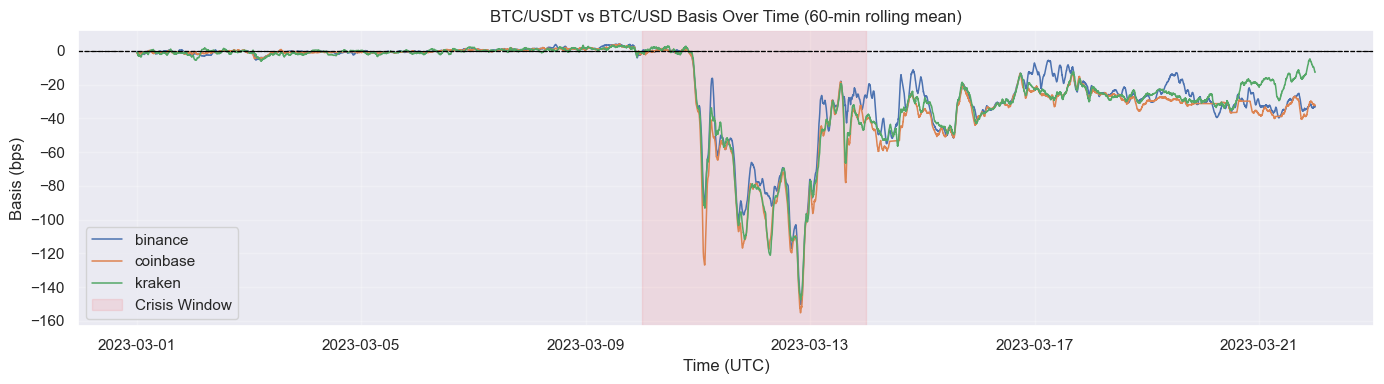

In [27]:
fig, ax = plt.subplots(figsize=(14, 4))
for ex in sorted(basis_ts_df["exchange"].unique()):
    x = basis_ts_df[basis_ts_df["exchange"] == ex].sort_values("time_bin").copy()
    # smooth for readability
    x["basis_roll"] = x["basis_bps"].rolling(60, min_periods=10).mean()  # 60-min rolling mean
    ax.plot(x["time_bin"], x["basis_roll"], linewidth=1.1, label=ex)

shade_crisis(ax)
ax.axhline(0, color="black", linestyle="--", linewidth=0.9)
ax.set_title("BTC/USDT vs BTC/USD Basis Over Time (60-min rolling mean)")
ax.set_ylabel("Basis (bps)")
ax.set_xlabel("Time (UTC)")
ax.grid(alpha=0.25)
ax.legend()
plt.tight_layout()
plt.show()

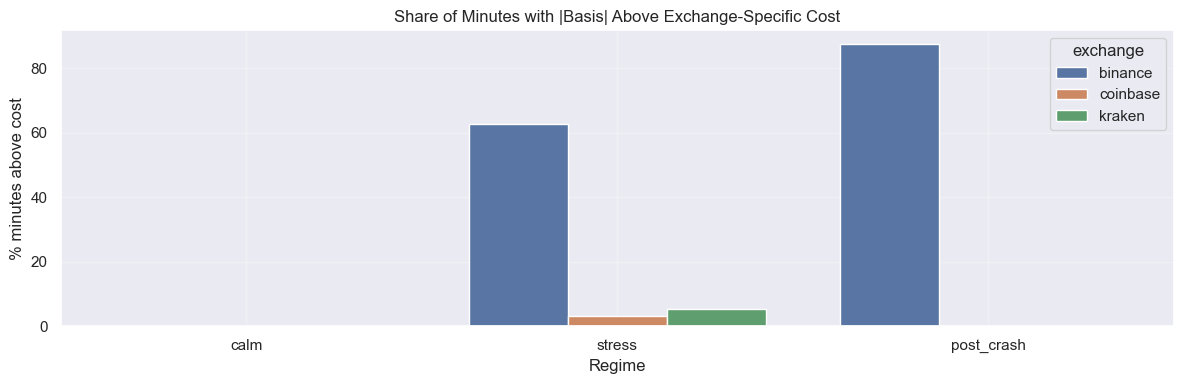

In [28]:
fig, ax = plt.subplots(figsize=(12, 4))
sns.barplot(
    data=basis_cost_summary_df,
    x="regime",
    y="pct_minutes_above_cost",
    hue="exchange",
    order=["calm", "stress", "post_crash"],
    ax=ax
)
ax.set_title("Share of Minutes with |Basis| Above Exchange-Specific Cost")
ax.set_ylabel("% minutes above cost")
ax.set_xlabel("Regime")
ax.grid(alpha=0.25)
plt.tight_layout()
plt.show()

## GENIUS Act

### Liquidity
The empirical findings of this study demonstrate that in the absence of federal regulation, stablecoins acted as vectors for traditional financial contagion. Without regulation, the depegging of USDC severely disrupted digital asset market microstructure. During the March 2023 banking stress, the collapse of SVB caused uncertainty surrounding stablecoin USDC reserve backing triggered a massive flight-to-volume, causing stablecoin volatility to surge to 200% and bid-ask spreads to widen by over 20x compared to calm market conditions (seen in Roll Spread). In stark contrast, native fiat USD order books maintained robust depth and stable execution costs, proving that the liquidity crisis was an artifact of stablecoin credit risk, not fundamental cryptocurrency valuation.

The GENIUS Act is a protection measure, and, more importanly, a critical prerequisite for market efficiency. By mandating strict reserve backing, transparent auditing, and direct oversight by banking regulators, the GENIUS Act effectively would have eliminated the informational asymmetry and default risk that forced market makers to drastically pull liquidity during the 2023 crisis. Under the new regulatory framework, stablecoins are transformed from speculative credit instruments into trusted, structurally sound settlement rails. Consequently, we question whether the GENIUS Act would have successfully eliminated the the systemic microstructure fragmentation observed in this study.  

While the empirical data demonstrates that fiat USD pairs maintain superior liquidity during stress events, it is critical to acknowledge the limitations of the GENIUS Act. If this regulatory framework had been active during the March 2023 crisis, it would not have fully insulated stablecoins from the observed microstructure breakdown.

First, the 2023 USDC depeg was not a failure of crypto-native collateral, but a manifestation of traditional commercial bank counterparty risk. Unless regulatory frameworks grant stablecoin issuers direct access to Federal Reserve Master Accounts, 1:1 reserve requirements merely transfer risk from the blockchain to uninsured deposits at commercial banks, leaving stablecoins vulnerable to fractional-reserve bank runs.

Second, regulation cannot resolve the temporal friction between continuous 24/7 cryptocurrency markets and legacy banking infrastructure. The evaporation of liquidity—evidenced by the 20x spike in the BTC/USDC Roll Spread—was severely exacerbated by the weekend closure of fiat settlement rails (Fedwire), which prevented arbitrageurs from minting and redeeming tokens to enforce the peg. Therefore, while the GENIUS Act improves transparency and baseline solvency, structural market fragmentation and volatility will persist during banking panics until continuous 24/7 fiat settlement infrastructure is fully realized.

### Fragmentation and CC Basis
The three-exchange evidence (Binance, Coinbase, Kraken) reinforces the same core diagnosis with stronger cross-sectional support: the main stress failure was not participation collapse, but pricing and convertibility friction. Volume fragmentation shows that leadership was mostly stable in BTC/USD (Coinbase-led) and BTC/USDT (Binance-led), with limited calm-to-stress dominant-share shifts under the 5pp significance rule; the only clear crash-time reallocation appears in BTC/USDC, where dominance flips toward Kraken in stress. In contrast, price alignment metrics deteriorate sharply: cross-venue dislocation rises materially in stress for BTC/USD and BTC/USDT, and most severely for BTC/USDC. Price-discovery timing remains fast (best lag = 0), but directional asymmetry increases under stress, especially in BTC/USDT where Binance’s predictive influence dominates. Cross-currency basis then confirms the same mechanism: BTC/USDT vs BTC/USD moves from near parity in calm to large, persistent stress/post-crash wedges. Taken together, markets stayed active and connected at the minute horizon, yet parity enforcement weakened exactly where redemption confidence, settlement certainty, and quote-currency trust become binding.

From a policy perspective, this pattern is precisely why regulated stablecoins can alter trading behavior. When market participants have stronger confidence in reserve quality, redemption mechanics, and supervisory credibility, the stablecoin-specific risk premium embedded in cross-currency pricing should compress. In microstructure terms, that should reduce stress-time basis persistence, lower dislocation tails, and restore more symmetric information flow across venues. The GENIUS Act (enacted July 18, 2025) is directionally aligned with these empirical weaknesses: reserve and disclosure requirements, issuer oversight, and redemption clarity target the channels through which trust shocks became pricing wedges in March 2023. Payment-network settlement adoption (e.g., card-network stablecoin rails) strengthens this channel further by improving practical settlement continuity and accelerating convergence.

At the same time, our results imply a clear boundary on what regulation can do. GENIUS-type rules can reduce stablecoin credit-opacity risk, but they cannot eliminate exchange-level liquidity withdrawal, inventory constraints, latency, fee heterogeneity, or broader fiat-rail bottlenecks during stress. This is visible in exchange-specific cost-adjusted basis outcomes: gross wedges are broad, but net persistence differs sharply by venue because market structure and trading frictions differ. The right policy benchmark is therefore not “zero dislocation,” but a measurable shift toward fewer, smaller, and shorter stress-time wedges, plus faster post-shock reintegration across venues and quote currencies.